# **NBA Career Prediction**
**Predict 5-Year Career Longevity for NBA Rookies**

## WEEK 3 - Feature Selection

**Team Name:** Group 1 

* Carol Myhill - 90014679
* Nathan Fragar - 93087548
* Nuwan Munasinghe - 13104409
* Sean Williams - ??
* Wenying Wu - 14007025 



In this project, we are trying to classify a rookie player will last at least five years in the NBA or not. This notebook will explore and visualise data and prepare datasets for modelling. The labels are included in the train data, and the goal is to train a model to learn to predict the labels from the features.

Classification: The label is a binary variable, 0 (if career years played < 5), 1 (if career years played >= 5)

This is one of the three notebook. In this notebook, we will explore and visualize data and prepare dataset for modeling. The main purpose of this notebook is to understand the data, try and identify relationships, trends, or anomalies that may help our modeling.

Features added include:
* '_anom'boolean columns which identify anomalies in the featrures
* knowledge features not included in original features
* '_per' per 48 Minites features to generalise the effect of MIN
* '_log' & '_sqr' log and squares features to fix the skewness and find hidden important features 

We then reduce the number of features using several methods. Including:
* remove features with value greater than a threshold percentage of missing values
* remove collinear features
* keep only the most relevant features using feature importances from a basic LightGBM model.

After feature selection, the performance of the features are tested using a reasonably basic LightGBM model.


**The steps are:**
1. Read Data
    * Import Libraries
    * Load data
2. Exploratory data analysis
3. Data visualization    
    
2. Fill values and create new boolean column 
3. Add features
4. Feature selection
5. Visualiztion

## 1. Read data

##### **[1.1]** Import all modules needed

In [1]:
# Essentials for for data manipulation
import pandas as pd
import numpy as np

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Stats
# from scipy.stats import skew, norm
# from scipy.special import boxcox1p
# from scipy.stats import boxcox_normmax

# Misc
from sklearn.metrics import silhouette_score
from featuretools import selection

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
# from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
# from imblearn.over_sampling import SMOTE
import sklearn.cluster as cluster
from joblib import dump
import lightgbm as lgb
# import gc


# Other
import warnings
warnings.filterwarnings(action="ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Use if need
# pd.set_option('display.max_columns', None)
# pd.options.display.max_seq_items = 8000
# pd.options.display.max_rows = 200

**Note:** Please download train.csv and test.csv from kaggle into data/raw folder.

##### **[1.2]** Get datasets

In [2]:
# Training data
df_train = pd.read_csv("../data/raw/train.csv")
print('Training data shape: ', df_train.shape)
df_train.head()

Training data shape:  (8000, 21)


Id  GP   MIN   PTS  FGM  FGA   FG%  3P Made  3PA   3P%  ...  FTA   FT%  \
0  10556  80  24.3   7.8  3.0  6.4  45.7      0.1  0.3  22.6  ...  2.9  72.1   
1   5342  75  21.8  10.5  4.2  7.9  55.1     -0.3 -1.0  34.9  ...  3.6  67.8   
2   5716  85  19.1   4.5  1.9  4.5  42.8      0.4  1.2  34.3  ...  0.6  75.7   
3  13790  63  19.1   8.2  3.5  6.7  52.5      0.3  0.8  23.7  ...  1.5  66.9   
4   5470  63  17.8   3.7  1.7  3.4  50.8      0.5  1.4  13.7  ...  0.5  54.0   

   OREB  DREB  REB  AST  STL  BLK  TOV  TARGET_5Yrs  
0   2.2   2.0  3.8  3.2  1.1  0.2  1.6            1  
1   3.6   3.7  6.6  0.7  0.5  0.6  1.4            1  
2   0.6   1.8  2.4  0.8  0.4  0.2  0.6            1  
3   0.8   2.0  3.0  1.8  0.4  0.1  1.9            1  
4   2.4   2.7  4.9  0.4  0.4  0.6  0.7            1  

[5 rows x 21 columns]

**Note:** The training data has 8,000 observations (each row represents a player) and 21 features including TARGET_5Yrs (the label we want to predict).

In [3]:
# Testing data
df_test = pd.read_csv("../data/raw/test.csv")
print('Testing data shape: ', df_test.shape)
df_test.head()

Testing data shape:  (3799, 20)


Id  GP   MIN   PTS  FGM   FGA   FG%  3P Made  3PA   3P%  FTM  FTA   FT%  \
0     1  56   9.1   4.0  1.6   3.7  43.7      0.1  0.3   7.3  0.7  1.2  63.4   
1  8194  43  19.3  10.1  3.7   8.1  46.0      0.6  1.7  35.1  1.8  2.5  75.3   
2     3  82  33.9  11.3  4.9  10.6  45.6      0.5  1.9  44.8  1.8  2.7  71.2   
3  8196  86  44.7  18.8  6.8  15.9  42.9      0.5  1.8  13.5  4.5  6.3  70.9   
4  8197  58  12.3   4.7  1.6   4.0  40.0      0.5  1.7  38.7  1.1  1.3  76.9   

   OREB  DREB  REB  AST  STL  BLK  TOV  
0   1.2   0.8  1.7  0.4  0.2  0.3  0.8  
1   0.5   0.9  1.5  3.5  0.6 -0.0  1.8  
2   1.3   3.3  4.5  2.5  1.3  0.3  2.0  
3   1.5   3.2  5.0  4.1  0.9  0.1  3.6  
4   0.2   0.6  0.9  1.5  0.5 -0.4  0.9

**Note:** The test set is considerably smaller, has 3,799 observations and lacks a TARGET_5Yrs column.

## 2. Exploratory Data Analysis

##### **[2.1]** Examine the distribution of target variable

1    0.833625
0    0.166375
Name: TARGET_5Yrs, dtype: float64

<AxesSubplot:ylabel='Frequency'>

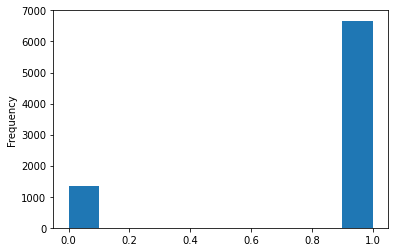

In [4]:
df_train['TARGET_5Yrs'].value_counts()/len(df_train)
df_train['TARGET_5Yrs'].astype(int).plot.hist()

**Note**: Target variable ('TARGET_5Yrs') is imbalanced. There are far more players that were played more or equal to 5 years than career years played less than 5 years. We can weight the classes by their representation in the data to reflect this imbalance. For example, we may consider SMOTE, Oversampling or other methods...


##### **[2.2]** Examine duplicate

In [5]:
# duplicate statistics
print("Train set")
print('There are %d of duplicated columns.' % (len(df_train['Id']) - len(df_train['Id'].unique())))
df_train[df_train.duplicated(keep=False)]

print()

print("Test set")
print('There are %d of duplicated columns.' % (len(df_test['Id']) - len(df_test['Id'].unique())))
df_test[df_test.duplicated(keep=False)]

Train set
There are 0 of duplicated columns.


Empty DataFrame
Columns: [Id, GP, MIN, PTS, FGM, FGA, FG%, 3P Made, 3PA, 3P%, FTM, FTA, FT%, OREB, DREB, REB, AST, STL, BLK, TOV, TARGET_5Yrs]
Index: []

[0 rows x 21 columns]


Test set
There are 0 of duplicated columns.


Empty DataFrame
Columns: [Id, GP, MIN, PTS, FGM, FGA, FG%, 3P Made, 3PA, 3P%, FTM, FTA, FT%, OREB, DREB, REB, AST, STL, BLK, TOV]
Index: []

**Note:** There are no duplicate in our trainset and testset

##### **[2.2]** Examine missing values

In [6]:
# Function to calculate missing values by column 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [7]:
# Missing values statistics
print("Train set")
missing_values = missing_values_table(df_train)
missing_values.head(20)

print()

print("Test set")
missing_values = missing_values_table(df_test)
missing_values.head(20)

Train set
Your selected dataframe has 21 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []


Test set
Your selected dataframe has 20 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

**Note:** There are no missing value in our train set and test set.

In [8]:
# check train columns and test columns
one_value_cols_train = [col for col in df_train.columns[:-1]]
one_value_cols_test = [col for col in df_test.columns]
one_value_cols_train == one_value_cols_test

True

**Note:** the columns in train and test are identical.


##### **[2.3]** Column types

In [9]:
# Display summary of train
# total values in each column, null/not null, datatype, memory occupied etc
print("Number of each type of column in train")
df_train.dtypes.value_counts()
df_train.info()

print()

print("Number of each type of column in test")
df_test.dtypes.value_counts()
df_test.info()

Number of each type of column in train


float64    18
int64       3
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Id           8000 non-null   int64  
 1   GP           8000 non-null   int64  
 2   MIN          8000 non-null   float64
 3   PTS          8000 non-null   float64
 4   FGM          8000 non-null   float64
 5   FGA          8000 non-null   float64
 6   FG%          8000 non-null   float64
 7   3P Made      8000 non-null   float64
 8   3PA          8000 non-null   float64
 9   3P%          8000 non-null   float64
 10  FTM          8000 non-null   float64
 11  FTA          8000 non-null   float64
 12  FT%          8000 non-null   float64
 13  OREB         8000 non-null   float64
 14  DREB         8000 non-null   float64
 15  REB          8000 non-null   float64
 16  AST          8000 non-null   float64
 17  STL          8000 non-null   float64
 18  BLK          8000 non-null   float64
 19  TOV   

float64    18
int64       2
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3799 entries, 0 to 3798
Data columns (total 20 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Id       3799 non-null   int64  
 1   GP       3799 non-null   int64  
 2   MIN      3799 non-null   float64
 3   PTS      3799 non-null   float64
 4   FGM      3799 non-null   float64
 5   FGA      3799 non-null   float64
 6   FG%      3799 non-null   float64
 7   3P Made  3799 non-null   float64
 8   3PA      3799 non-null   float64
 9   3P%      3799 non-null   float64
 10  FTM      3799 non-null   float64
 11  FTA      3799 non-null   float64
 12  FT%      3799 non-null   float64
 13  OREB     3799 non-null   float64
 14  DREB     3799 non-null   float64
 15  REB      3799 non-null   float64
 16  AST      3799 non-null   float64
 17  STL      3799 non-null   float64
 18  BLK      3799 non-null   float64
 19  TOV      3799 non-null   float64
dtypes: float64(18), int64(2)
memory usage: 593.7 KB


**Note:** TARGET_5Yrs is a categorical varaible, which has already been encoding, in Dtype int64.

##### **[2.4]** Display descriptive data of train and test dataframe

In [10]:
df_train.describe()

Id           GP          MIN          PTS          FGM  \
count   8000.000000  8000.000000  8000.000000  8000.000000  8000.000000   
mean    6856.971000    62.777875    18.576662     7.267088     2.807037   
std     3977.447579    17.118774     8.935263     4.318732     1.693373   
min        4.000000    -8.000000     2.900000     0.800000     0.300000   
25%     3413.750000    51.000000    12.000000     4.100000     1.600000   
50%     6787.500000    63.000000    16.800000     6.300000     2.400000   
75%    10299.250000    74.000000    23.500000     9.500000     3.700000   
max    13798.000000   123.000000    73.800000    34.200000    13.100000   

               FGA          FG%      3P Made          3PA          3P%  ...  \
count  8000.000000  8000.000000  8000.000000  8000.000000  8000.000000  ...   
mean      6.231212    44.608900     0.264525     0.816562    19.583700  ...   
std       3.584559     6.155453     0.384093     1.060964    16.003155  ...   
min       0.800000    21.300000    -1.100000    -3.100000   -38.500000  ...   
25%       3.600000    40.400000     0.000000     0.100000     8.400000  ...   
50%       5.400000    44.400000     0.300000     0.800000    19.500000  ...   
75%       8.100000    48.700000     0.500000     1.500000    30.600000  ...   
max      28.900000    67.200000     1.700000     4.700000    82.100000  ...   

               FTA          FT%         OREB         DREB          REB  \
count  8000.000000  8000.000000  8000.000000  8000.000000  8000.000000   
mean      1.947788    71.365825     1.077838     2.168500     3.245300   
std       1.252352    10.430447     0.785670     1.392224     2.085154   
min       0.000000   -13.300000     0.000000     0.200000     0.300000   
25%       1.000000    65.000000     0.500000     1.100000     1.700000   
50%       1.700000    71.400000     0.900000     1.900000     2.800000   
75%       2.600000    77.500000     1.500000     2.900000     4.300000   
max      11.100000   168.900000     5.500000    11.000000    15.900000   

               AST          STL          BLK          TOV  TARGET_5Yrs  
count  8000.000000  8000.000000  8000.000000  8000.000000  8000.000000  
mean      1.624513     0.648687     0.245212     1.257763     0.833625  
std       1.355986     0.407626     0.821037     0.723270     0.372440  
min       0.000000     0.000000   -17.900000     0.100000     0.000000  
25%       0.700000     0.300000     0.100000     0.700000     1.000000  
50%       1.300000     0.600000     0.200000     1.100000     1.000000  
75%       2.200000     0.900000     0.400000     1.600000     1.000000  
max      12.800000     3.600000    18.900000     5.300000     1.000000  

[8 rows x 21 columns]

In [11]:
df_test.describe()

Id           GP          MIN          PTS          FGM  \
count   3799.000000  3799.000000  3799.000000  3799.000000  3799.000000   
mean    7010.614109    62.853909    18.650224     7.328034     2.835404   
std     3954.173641    17.151740     8.727259     4.294724     1.688427   
min        1.000000     6.000000     3.700000     0.700000     0.300000   
25%     3644.000000    51.000000    12.200000     4.200000     1.600000   
50%     7062.000000    63.000000    17.000000     6.400000     2.500000   
75%    10402.500000    74.000000    23.300000     9.400000     3.700000   
max    13792.000000   126.000000    68.000000    33.000000    13.400000   

               FGA          FG%      3P Made          3PA          3P%  \
count  3799.000000  3799.000000  3799.000000  3799.000000  3799.000000   
mean      6.302580    44.599079     0.255962     0.796920    19.234746   
std       3.579221     6.040168     0.380987     1.052862    15.968989   
min       0.800000    25.100000    -1.000000    -2.700000   -38.000000   
25%       3.700000    40.500000    -0.000000     0.100000     8.500000   
50%       5.500000    44.600000     0.300000     0.800000    19.400000   
75%       8.100000    48.500000     0.500000     1.500000    30.250000   
max      26.200000    74.600000     1.600000     4.300000    73.800000   

               FTM          FTA          FT%         OREB         DREB  \
count  3799.000000  3799.000000  3799.000000  3799.000000  3799.000000   
mean      1.399842     1.953567    71.612924     1.096025     2.179495   
std       0.926140     1.250376    10.457336     0.785678     1.371935   
min       0.000000     0.000000    23.700000     0.000000     0.200000   
25%       0.700000     1.000000    65.000000     0.500000     1.200000   
50%       1.200000     1.700000    71.500000     0.900000     1.900000   
75%       1.900000     2.600000    78.000000     1.500000     2.900000   
max       7.800000     9.800000   127.100000     6.900000    12.000000   

               REB          AST          STL          BLK          TOV  
count  3799.000000  3799.000000  3799.000000  3799.000000  3799.000000  
mean      3.275783     1.636483     0.653593     0.257726     1.257910  
std       2.070646     1.335496     0.410573     0.639660     0.712449  
min       0.300000     0.000000     0.000000    -7.100000     0.100000  
25%       1.800000     0.600000     0.400000     0.100000     0.700000  
50%       2.800000     1.300000     0.600000     0.200000     1.100000  
75%       4.300000     2.300000     0.900000     0.400000     1.600000  
max      18.500000     9.000000     2.700000    14.800000     5.200000

##### **[2.5]** EDA summary 

1. There are some columns has anomalies value. For example, MIN has max value in 73.8 in train and 68 in test, which is not likely, given 48mins/game. -> examine number of instances
2. FT% has max value > 100 in train and test, not possible -> examine number of instances.
3. Columns containing negative values in both train and test, but these values should not be negative: 
* Train set: GP, 3P Made, 3PA, 3P%, BLK, FT% 
* Test set: 3P Made, 3PA, 3P%, BLK
* Columns containing negative values in Train only: GP, FT%

## 3. Data visualization

Now that we have dealt with the categorical variable and the outliers.
We can understand the data better by looking for correlations between the features and the target. Calculate the Pearson correlation coefficient between every variable and the target using the .corr dataframe method.

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some general interpretations of the absolute value of the correlation coefficent are:

* .00-.19 “very weak”
* .20-.39 “weak”
* .40-.59 “moderate”
* .60-.79 “strong”
* .80-1.0 “very strong”

##### **[3.1]** Correlation between X and y

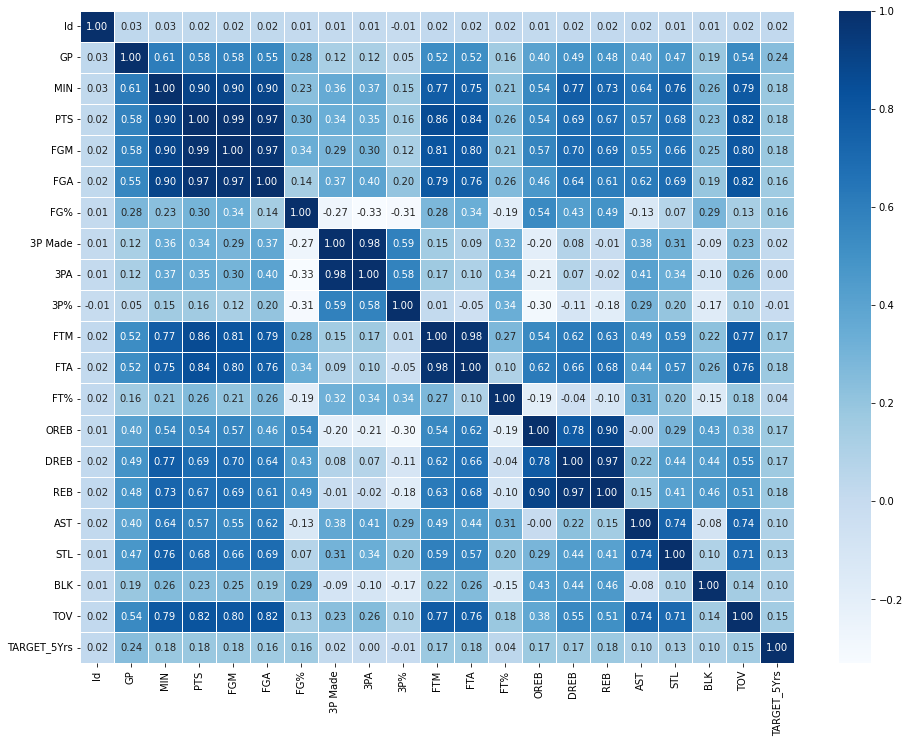

In [12]:
corr_matrix = df_train.corr()
fig, ax = plt.subplots(figsize=(16,12))
ax = sns.heatmap(corr_matrix, annot=True, linewidths=0.5, fmt=".2f", cmap="Blues")

In [13]:
# Find correlations with the Target and sort
correlations = df_train.corr()['TARGET_5Yrs'].sort_values()

# Display correlations with Target
print('Most Positive Correlations with Target:')
correlations.tail(10)

print()

print('Most Negative Correlations with Target:') 
correlations.head(10)

Most Positive Correlations with Target:


DREB           0.168065
OREB           0.172604
FTM            0.173913
REB            0.175627
FTA            0.176525
PTS            0.182004
MIN            0.182203
FGM            0.183568
GP             0.242108
TARGET_5Yrs    1.000000
Name: TARGET_5Yrs, dtype: float64


Most Negative Correlations with Target:


3P%       -0.011977
3PA        0.003463
3P Made    0.015016
Id         0.018233
FT%        0.039429
AST        0.096771
BLK        0.098642
STL        0.128381
TOV        0.151240
FG%        0.158858
Name: TARGET_5Yrs, dtype: float64

**Note:** the 'GP' is the most positive correlation. (except 'TARGET_5Yrs' because the correlation of a variable with itself is always 1) 

##### **[3.2]** Distribution of all variables

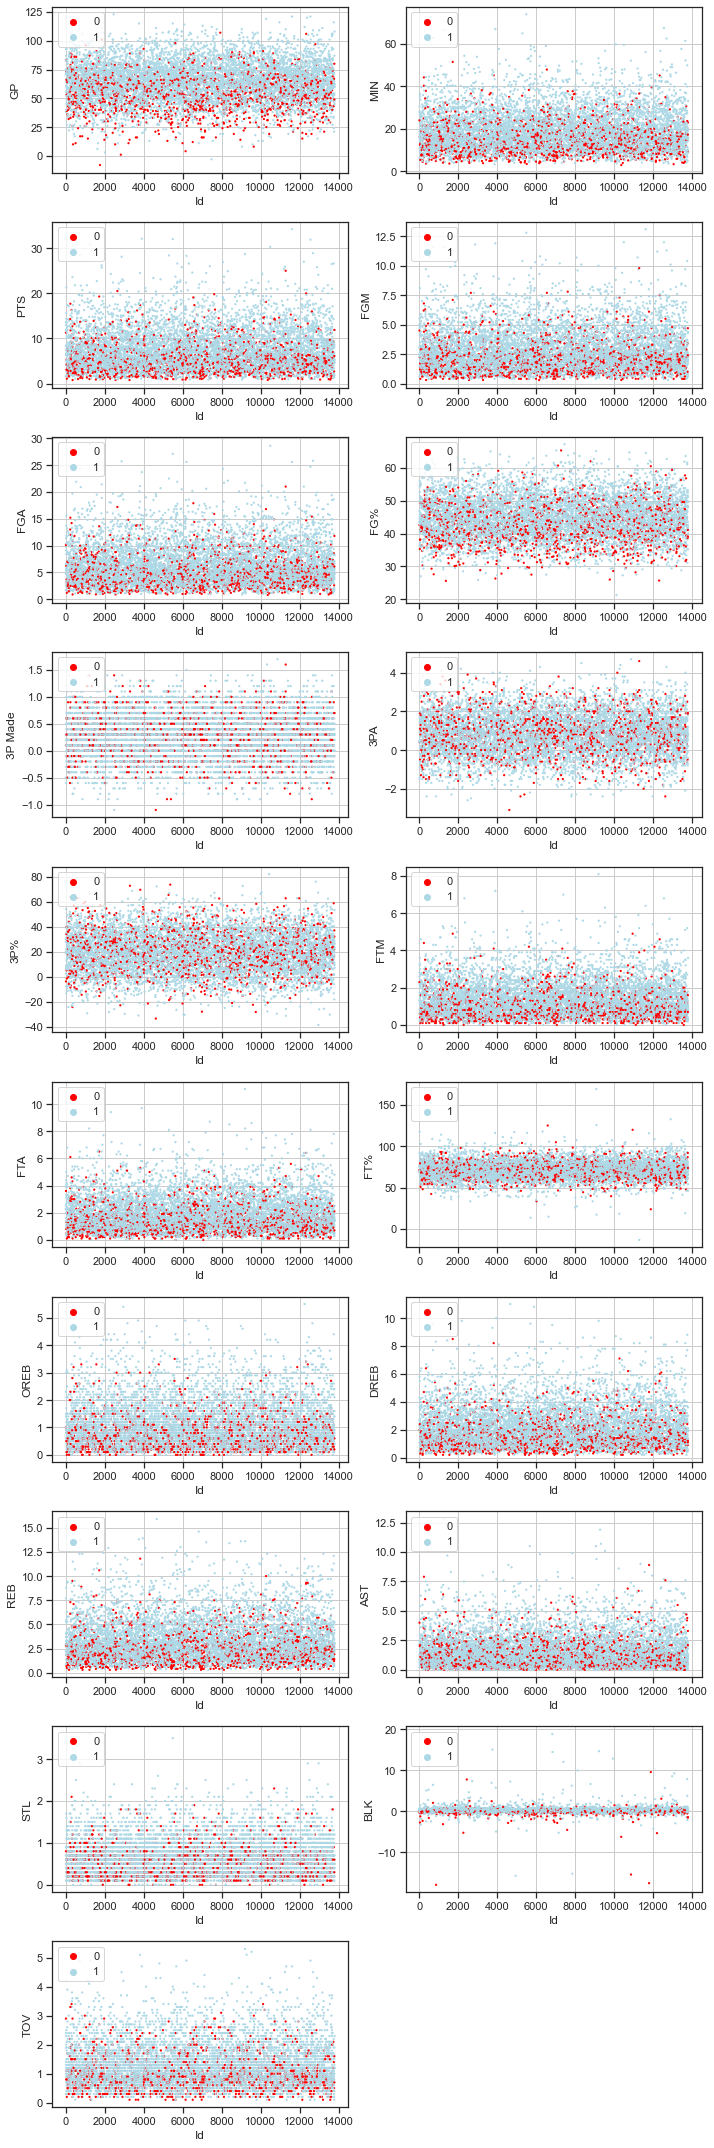

In [14]:
sns.set_theme(style="ticks")
plt.figure(figsize = (10,30))
nrow = 10
ncol = 2
i = 1 
for variable in df_train.drop(columns = ['Id','TARGET_5Yrs']):
    plt.grid()
    plt.subplot(nrow, ncol, i)
    sns.scatterplot(x = "Id", y = variable, hue = "TARGET_5Yrs", data = df_train, 
                    legend = 'full',edgecolor = 'none', s = 5, palette=['red','lightblue']);
    i += 1
    plt.legend(loc=2)
plt.tight_layout()
plt.show();

**Note**: We can see for all features, variables with 'TARGET_5Yrs' = 0 (red points) are generally positioned lower than variables with 'TARGET_5Yrs' = 1.

##### **[3.3]** Violin plot of all variables

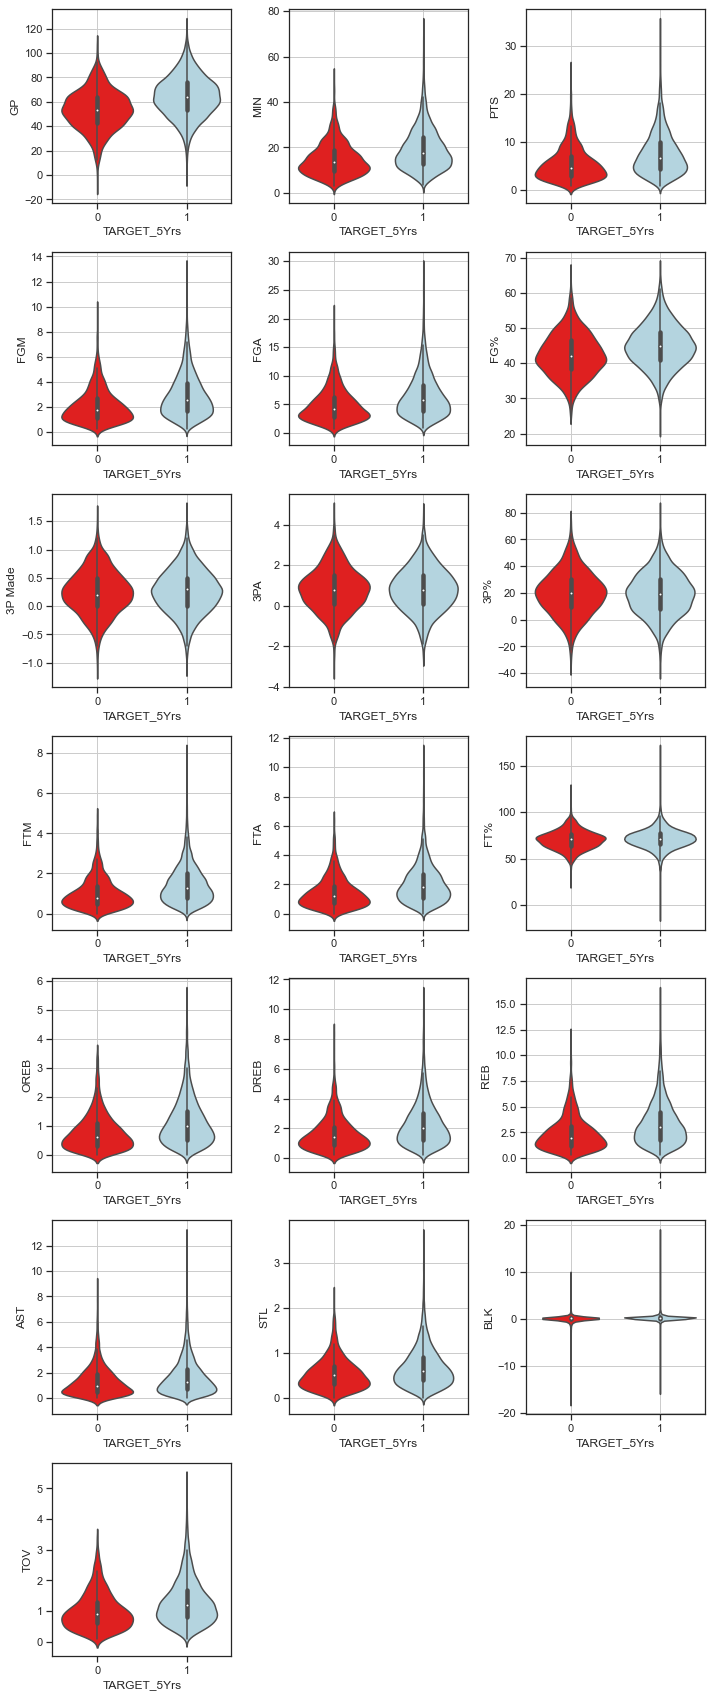

In [15]:
plt.figure(figsize = (10,30))
nrow = 9
ncol = 3
i = 1 
for variable in df_train.drop(columns = ['Id','TARGET_5Yrs']):
    plt.grid()
    plt.subplot(nrow, ncol, i)
    sns.violinplot(x = "TARGET_5Yrs", y = variable, data = df_train, palette=['red','lightblue'])
    #plt.legend()
    i += 1
   # plt.legend(loc=2)
plt.tight_layout()
plt.show();

**Note:** From the violin plots, we can see almost all the variables generally have higher values when 'TARGET_5Yrs' = 1.
Especially: 'GP', 'MIN', 'PTS' 'FGM', 'FGA', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV'.

##### **[3.4]** Pairplot for selected variables

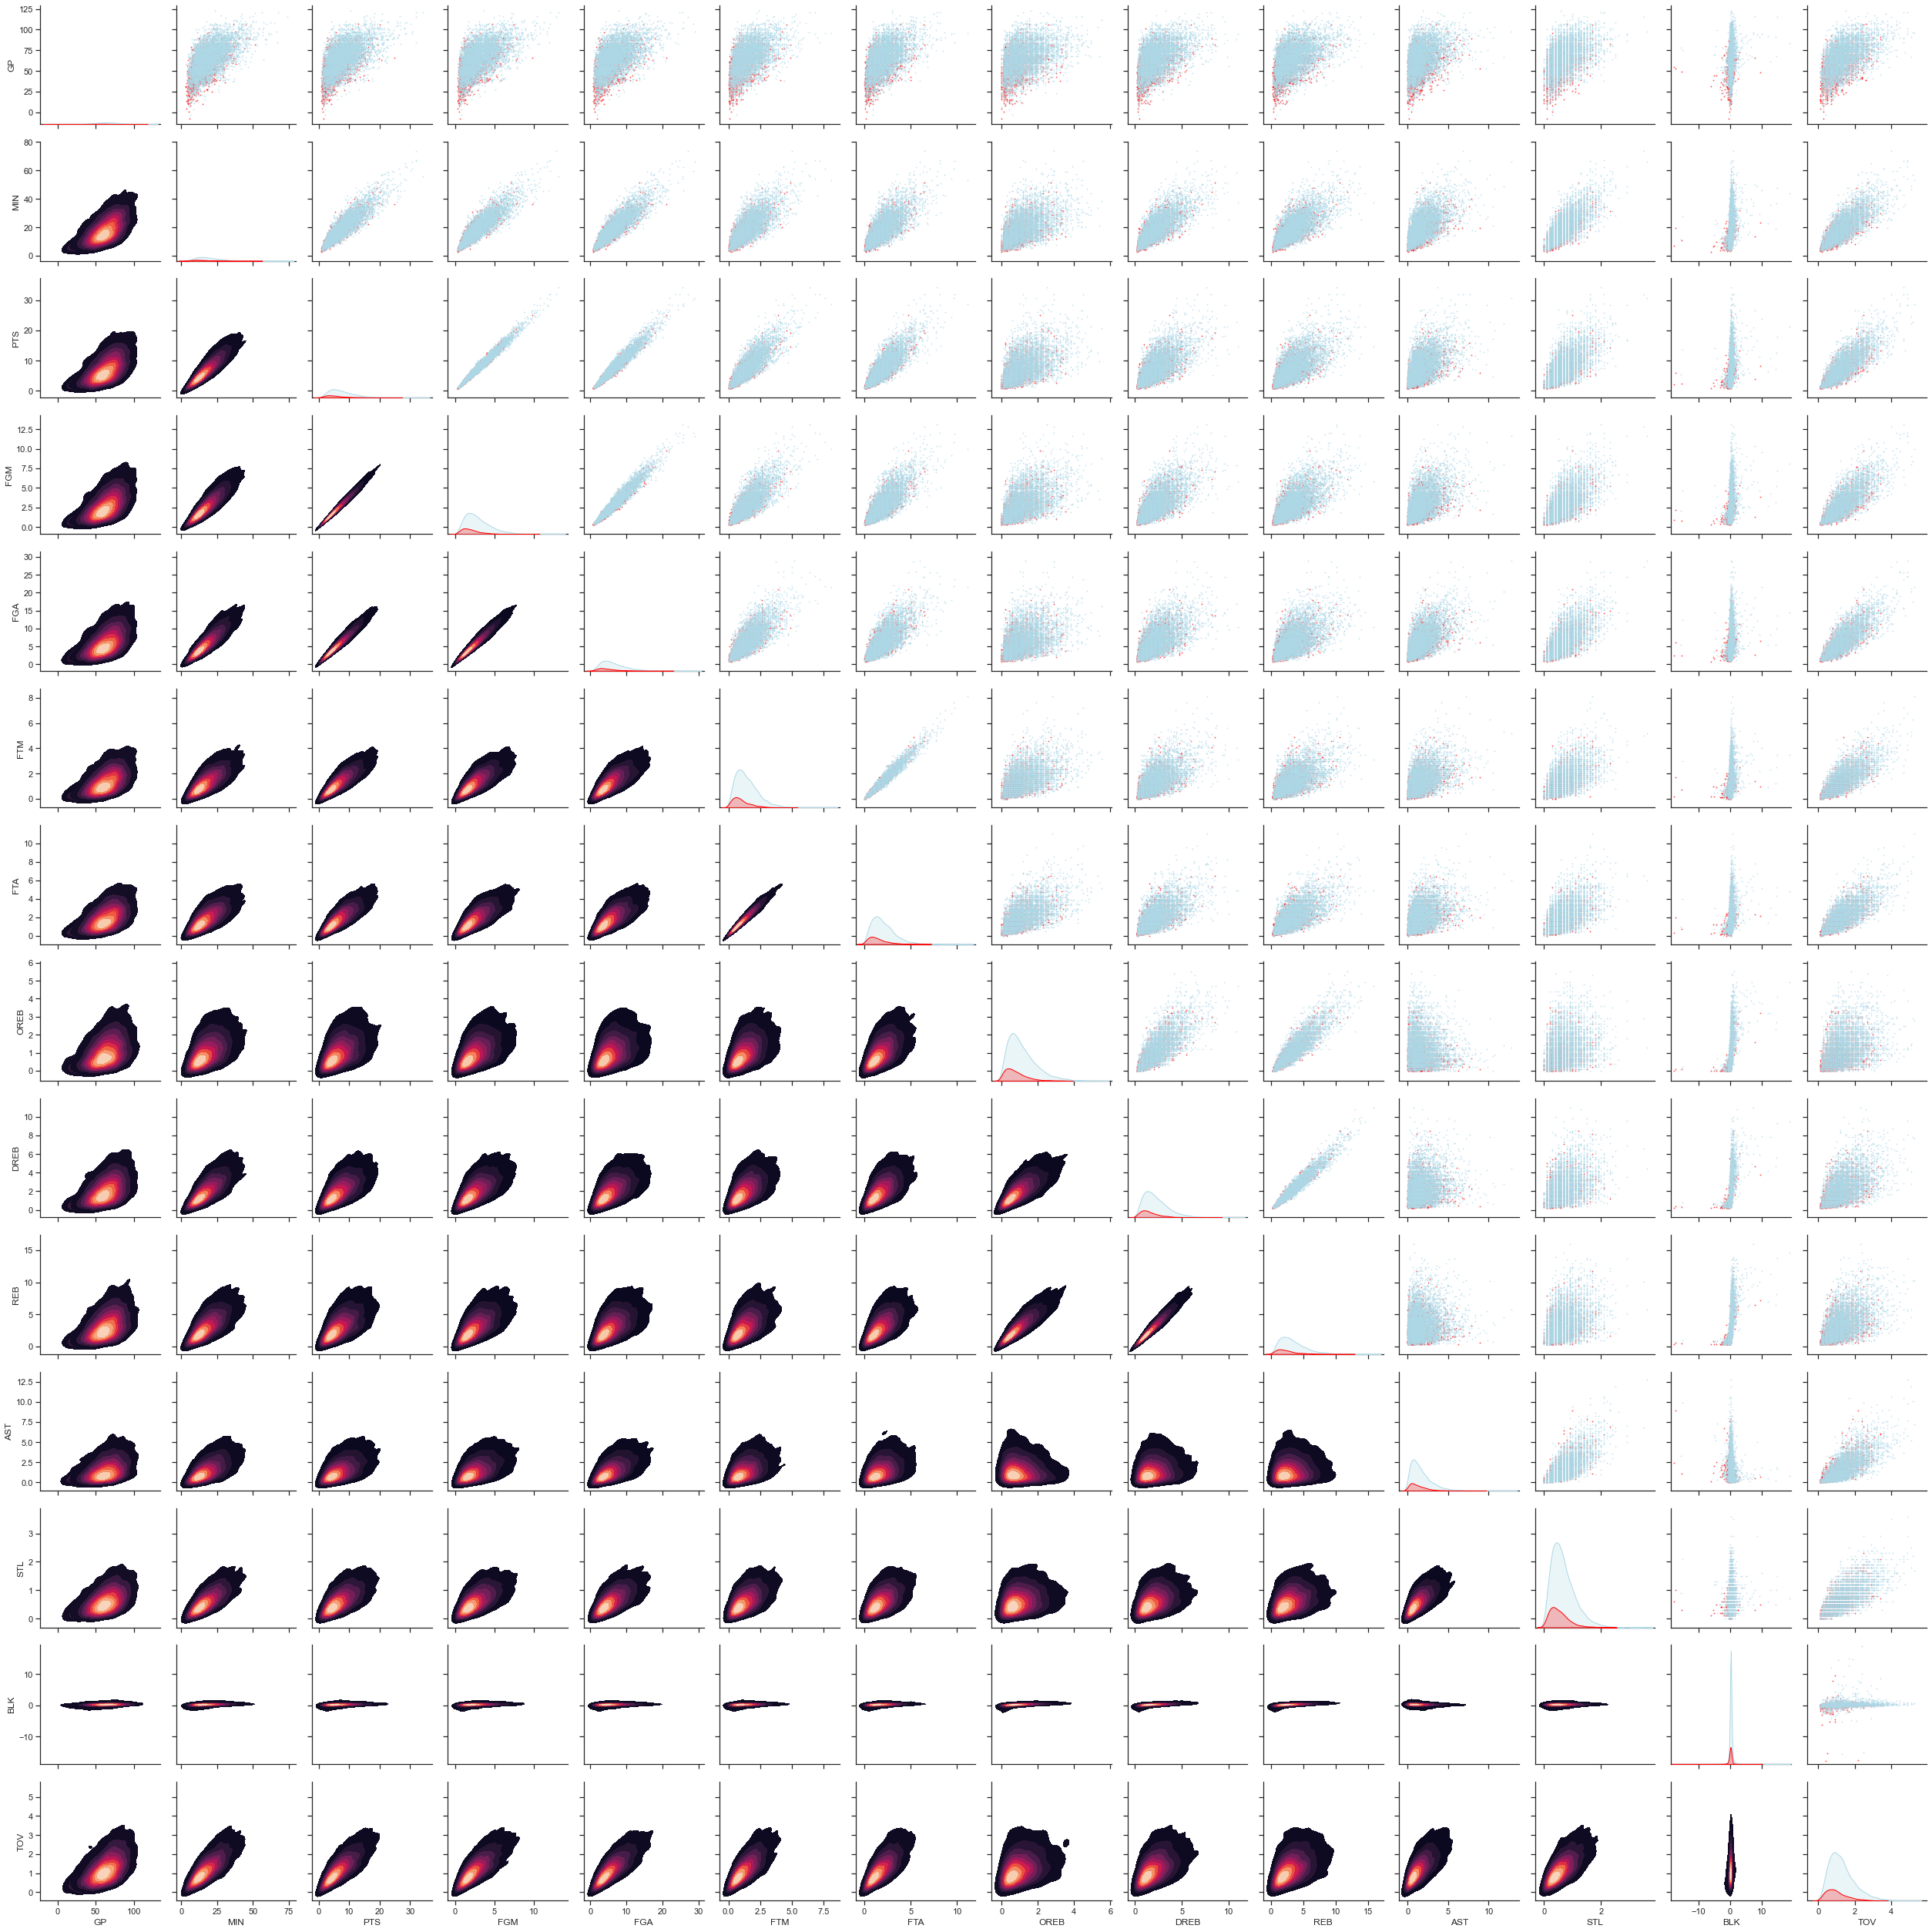

In [16]:
def infer_cmap(color):
    hues = ['red','lightblue']
    if color == hues[0]:
        return 'Reds'
    elif color == hues[1]:
        return 'lightBlues'

def kde_color_plot(x, y, **kwargs):
    cmap = infer_cmap(kwargs['color'])
    ax = sns.kdeplot(x, y, shade=True, shade_lowest=False, cmap=cmap, **kwargs)
    return ax

g = sns.PairGrid(df_train[['GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'TARGET_5Yrs']], 
                 vars=('GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV'), 
                 hue='TARGET_5Yrs', palette=['red','lightblue'])
g = g.map_upper(plt.scatter, s=1, alpha=0.5)
g = g.map_lower(kde_color_plot)
g = g.map_diag(sns.kdeplot, shade=True);
plt.tight_layout()
plt.show();

**Note:** In variabel 'GP', 'MIN', 'PTS' 'FGM', 'FGA', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', we can see almost all the features have a positive relationship with the other features. TARGET_5Yrs = 1 is shown in blue, which is slightly higher than red TARGET_5Yrs = 0.
In addition, some variables' distribution is right skewed, for example 'FGM', 'FGA', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST' and 'STL', which could be an indication of large amount of outliers with large values and potential usage of log transformation.

##### **[3.5]** Check the number of anomalies value

In [17]:
# MIN > 48
print("number of anomalies value of MIN > 48 in (train, test):")
len(df_train[df_train["MIN"] > 48].index), len(df_test[df_test["MIN"] > 48].index)

# FT% > 100
print("number of anomalies value in FT > 100 in (train, test):")
len(df_train[df_train["FT%"] > 100].index), len(df_test[df_test["FT%"] > 100].index)

# Find % of all columns containing negative values in train and test
print("% of negative values of each column in train")
(df_train < 0).sum(axis = 0)/df_train.shape[0]

print()

print("% of negative values of each column in test")
(df_test < 0).sum(axis = 0)/df_test.shape[0]


# Further investigate negative values
df_train[df_train["GP"] < 0].index
df_train[df_train["FT%"] < 0].index

name_list = ["3P Made", "3PA", "3P%", "BLK"]
for name in name_list:
    print(f"No. of Negative values in column '{name}' in (train, test): ({len(df_train[df_train[name] < 0].index)}, {len(df_test[df_test[name] < 0].index)})")


number of anomalies value of MIN > 48 in (train, test):


(56, 19)

number of anomalies value in FT > 100 in (train, test):


(58, 30)

% of negative values of each column in train


Id             0.000000
GP             0.000250
MIN            0.000000
PTS            0.000000
FGM            0.000000
FGA            0.000000
FG%            0.000000
3P Made        0.203625
3PA            0.207250
3P%            0.109750
FTM            0.000000
FTA            0.000000
FT%            0.000125
OREB           0.000000
DREB           0.000000
REB            0.000000
AST            0.000000
STL            0.000000
BLK            0.131000
TOV            0.000000
TARGET_5Yrs    0.000000
dtype: float64


% of negative values of each column in test


Id         0.000000
GP         0.000000
MIN        0.000000
PTS        0.000000
FGM        0.000000
FGA        0.000000
FG%        0.000000
3P Made    0.204001
3PA        0.203475
3P%        0.114504
FTM        0.000000
FTA        0.000000
FT%        0.000000
OREB       0.000000
DREB       0.000000
REB        0.000000
AST        0.000000
STL        0.000000
BLK        0.120032
TOV        0.000000
dtype: float64

Int64Index([5323, 7400], dtype='int64')

Int64Index([3059], dtype='int64')

No. of Negative values in column '3P Made' in (train, test): (1629, 775)
No. of Negative values in column '3PA' in (train, test): (1658, 773)
No. of Negative values in column '3P%' in (train, test): (878, 435)
No. of Negative values in column 'BLK' in (train, test): (1048, 456)


##### **[3.6]** Data visualization summary

There are a lot of anomalies values, especially negative values in the dataset. We will fill values with np.nan and create boolean columns indicating whether or not the values was anomalous in later steps. 
Considering this dataset has no missing value originally, filling with np.nan would be sufficient to distinguish anomalies, it would also provide potential to be filled by different values (0/mean/median/mode) in later section.

## 4. Data Cleaning

* Recalculate some variables that are calculated incorrectly
* Fill in the anomalous values with not a number (np.nan) and then create a new boolean column indicating whether or not the value was anomalous.

Re-read data in this section for future convienience (skip EDA and start from this section).

##### **[4.1]** Prepare dataset for following steps

Combine train and test X in order to apply the feature transformation pipeline to the entire dataset.

In [18]:
# Read data in notebook
df_train = pd.read_csv("../data/raw/train.csv", index_col=0)
print('Training data shape: ', df_train.shape)

df_test = pd.read_csv("../data/raw/test.csv", index_col=0)
print('Testing data shape: ', df_test.shape)

# Split X and y, X is all features, y is our target
X_train_raw = df_train.drop(['TARGET_5Yrs'], axis=1)
y_train_raw = df_train['TARGET_5Yrs']
X_test_raw = df_test

# Make a copy of raw dataset, make sure we can check our raw data when we anaysis
X_train = X_train_raw.copy()
y_train = y_train_raw.copy()
X_test  = X_test_raw.copy()

# Combine train and test X
all_X = pd.concat([X_train, X_test]).reset_index(drop=False).set_index('Id')
all_X.head()

Training data shape:  (8000, 20)
Testing data shape:  (3799, 19)


GP   MIN   PTS  FGM  FGA   FG%  3P Made  3PA   3P%  FTM  FTA   FT%  \
Id                                                                          
10556  80  24.3   7.8  3.0  6.4  45.7      0.1  0.3  22.6  2.0  2.9  72.1   
5342   75  21.8  10.5  4.2  7.9  55.1     -0.3 -1.0  34.9  2.4  3.6  67.8   
5716   85  19.1   4.5  1.9  4.5  42.8      0.4  1.2  34.3  0.4  0.6  75.7   
13790  63  19.1   8.2  3.5  6.7  52.5      0.3  0.8  23.7  0.9  1.5  66.9   
5470   63  17.8   3.7  1.7  3.4  50.8      0.5  1.4  13.7  0.2  0.5  54.0   

       OREB  DREB  REB  AST  STL  BLK  TOV  
Id                                          
10556   2.2   2.0  3.8  3.2  1.1  0.2  1.6  
5342    3.6   3.7  6.6  0.7  0.5  0.6  1.4  
5716    0.6   1.8  2.4  0.8  0.4  0.2  0.6  
13790   0.8   2.0  3.0  1.8  0.4  0.1  1.9  
5470    2.4   2.7  4.9  0.4  0.4  0.6  0.7

In [19]:
# Save y_train_raw for later use
y_train_raw.to_csv("../data/processed/y_train_raw.csv", index = False)

##### **[4.2]** Recalculate variables

From last week, we find FT% calculated based on FTM and FTA is having a maximum value of 200% which is impossible, which means there are hidden problems in FTM & FTA. Also, NBA official highest 3P% is around 45%, which is much lower than the maximum 82.1% here, recalculate 3P%.

Recalculate four variables FT%, 3P%, FG%, REB contained in the raw test dataset, which can be calculated based on the other variables in the same dataset.

In [20]:
# recalculate FT%, since the FT% > 100 is not possible
all_X['FT%'] = all_X['FTM'] / all_X['FTA'] * 100

# recalculate 3P%, since NBA official highest 3P% is around 45%
all_X['3P%'] = all_X['3P Made'] / all_X['3PA'] * 100

# recalculate FG%, since above 2 columns are wrong, check for correctness
all_X['FG%'] = all_X['FGM'] / all_X['FGA'] * 100

# recalculate REB
all_X['REB'] = all_X['OREB'] + all_X['DREB']

# # check step, uncomment to see 
# all_X.describe()
# all_X.info()

Check columns after recalculating four variables.

In [21]:
# # check step, uncomment to see 

# # Use if need:
# # pd.options.display.max_rows = 8000

# # find 3P% = inf - 162 rows
# print("Rows of 3P% = inf")
# all_X[np.isinf(all_X['3P%'])]
# print()

# # 3P Made > 3PA, 2221 rows
# print("Rows of 3P Made > 3PA")
# all_X[all_X['3P Made'] > all_X['3PA']]
# print()

# # 3P% = nan, 163 rows
# print("Rows of 3P% = nan")
# all_X[np.isnan(all_X['3P%'])]
# print()

# # FG% = nan, 0 rows
# print("Rows of FG% = nan")
# all_X[np.isnan(all_X['FG%'])]
# print()

# # FT = nan,  9 rows
# print("Rows of FT = nan")
# all_X[np.isnan(all_X['FT%'])]
# print()

# # Check info
# print("Check info")
# all_X.info()
# print()

# # Check dataframe
# print("Check describe")
# all_X.describe()

##### **[4.3]** Fill % realated anomalies value with np.nan

From the result above, we find there are still a lot of anomalies values. For example, 3P made is higher than 3PA, which is impossible. We will change it as np.nan if the value is not correct.

In [22]:
# Use if need:
# pd.set_option('display.max_columns', None)

# Change inf as nan
all_X.loc[np.isinf(all_X['3P%']), '3P%'] = np.nan

# Create anomalous flag columns and replace the anomalous values with nan
# Create a dic 
cal_variables = [['3P Made', '3PA', '3P%'],
          ['FTM', 'FTA', 'FT%'],
          ['FGM', 'FGA', 'FG%']]

for col in cal_variables:
    if (all_X[col[0]] > all_X[col[1]]).any():
        for i in range(3):
            all_X[f'{col[i]}_anom'] = all_X[col[0]] > all_X[col[1]]
            all_X[f'{col[i]}_anom'] = all_X[f'{col[i]}_anom'].replace({True: 1, False: 0})
        all_X.loc[all_X[col[0]] > all_X[col[1]], [col[0], col[1], col[2]]] = np.nan 


# Recheck dataframe
all_X.describe()

GP           MIN           PTS           FGM           FGA  \
count  11799.000000  11799.000000  11799.000000  11799.000000  11799.000000   
mean      62.802356     18.600347      7.286711      2.816171      6.254191   
std       17.128705      8.868520      4.310929      1.691763      3.582845   
min       -8.000000      2.900000      0.700000      0.300000      0.800000   
25%       51.000000     12.050000      4.100000      1.600000      3.600000   
50%       63.000000     16.900000      6.400000      2.400000      5.500000   
75%       74.000000     23.400000      9.500000      3.700000      8.100000   
max      126.000000     73.800000     34.200000     13.400000     28.900000   

                FG%      3P Made          3PA          3P%           FTM  ...  \
count  11799.000000  9578.000000  9578.000000  9294.000000  11735.000000  ...   
mean      44.639429     0.382888     1.159543    33.778950      1.396651  ...   
std        6.230051     0.304823     0.820547    25.624378      0.926852  ...   
min       25.000000    -0.300000    -0.300000  -200.000000      0.000000  ...   
25%       40.322581     0.200000     0.500000    28.571429      0.700000  ...   
50%       44.444444     0.300000     1.100000    33.333333      1.200000  ...   
75%       48.648649     0.600000     1.700000    38.461538      1.900000  ...   
max       81.250000     1.700000     4.700000   300.000000      8.100000  ...   

                AST           STL           BLK           TOV  3P Made_anom  \
count  11799.000000  11799.000000  11799.000000  11799.000000  11799.000000   
mean       1.628367      0.650267      0.249241      1.257810      0.188236   
std        1.349378      0.408566      0.767327      0.719774      0.390917   
min        0.000000      0.000000    -17.900000      0.100000      0.000000   
25%        0.700000      0.400000      0.100000      0.700000      0.000000   
50%        1.300000      0.600000      0.200000      1.100000      0.000000   
75%        2.200000      0.900000      0.400000      1.600000      0.000000   
max       12.800000      3.600000     18.900000      5.300000      1.000000   

           3PA_anom      3P%_anom      FTM_anom      FTA_anom      FT%_anom  
count  11799.000000  11799.000000  11799.000000  11799.000000  11799.000000  
mean       0.188236      0.188236      0.005424      0.005424      0.005424  
std        0.390917      0.390917      0.073452      0.073452      0.073452  
min        0.000000      0.000000      0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000      0.000000      0.000000  
50%        0.000000      0.000000      0.000000      0.000000      0.000000  
75%        0.000000      0.000000      0.000000      0.000000      0.000000  
max        1.000000      1.000000      1.000000      1.000000      1.000000  

[8 rows x 25 columns]

The described table looks reasonable after the above step.

Create a function to check the missing values in the dataset.

In [23]:
# Function to calculate missing values by column 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [24]:
# Missing values statistics
print("Train set")
missing_values = missing_values_table(all_X)
missing_values.head(20)

Train set
Your selected dataframe has 25 columns.
There are 6 columns that have missing values.


Missing Values  % of Total Values
3P%                2505               21.2
3P Made            2221               18.8
3PA                2221               18.8
FT%                  73                0.6
FTM                  64                0.5
FTA                  64                0.5

3P%, 3P Made, 3PA has the highest percentage of missing values based on the total values, around 20%. In other words, there are about 20% of anomalies values in each of these columns. Let's double check the missing values.

In [25]:
all_X[np.isnan(all_X['3P Made'])]

GP   MIN   PTS  FGM  FGA        FG%  3P Made  3PA  3P%  FTM  ...  AST  \
Id                                                                  ...        
5342   75  21.8  10.5  4.2  7.9  53.164557      NaN  NaN  NaN  2.4  ...  0.7   
1961   88  20.0   8.8  3.7  8.7  42.528736      NaN  NaN  NaN  2.0  ...  1.8   
2677   70  20.6   7.0  3.2  5.4  59.259259      NaN  NaN  NaN  0.7  ...  0.6   
13144  41   9.8   2.3  0.9  2.3  39.130435      NaN  NaN  NaN  0.9  ...  0.2   
3062   83   8.5   2.2  0.9  1.8  50.000000      NaN  NaN  NaN  0.5  ...  1.3   
...    ..   ...   ...  ...  ...        ...      ...  ...  ...  ...  ...  ...   
8148   64  10.4   3.1  1.3  3.6  36.111111      NaN  NaN  NaN  0.5  ...  1.4   
8165   59   8.6   2.8  1.3  2.3  56.521739      NaN  NaN  NaN  0.3  ...  0.0   
8166   60  11.7   7.2  3.2  5.7  56.140351      NaN  NaN  NaN  0.8  ...  0.5   
8176   49  16.3   6.4  2.9  6.6  43.939394      NaN  NaN  NaN  1.0  ...  0.4   
8178   53   9.9   2.1  0.8  1.8  44.444444      NaN  NaN  NaN  0.6  ...  0.4   

       STL  BLK  TOV  3P Made_anom  3PA_anom  3P%_anom  FTM_anom  FTA_anom  \
Id                                                                           
5342   0.5  0.6  1.4             1         1         1         0         0   
1961   0.4  0.3  1.1             1         1         1         0         0   
2677   0.4  0.7  1.2             1         1         1         0         0   
13144  0.3  0.4  0.4             1         1         1         0         0   
3062   0.4  0.2  0.8             1         1         1         0         0   
...    ...  ...  ...           ...       ...       ...       ...       ...   
8148   0.5 -0.0  0.9             1         1         1         0         0   
8165   0.1  0.6  0.2             1         1         1         0         0   
8166   0.5  0.2  1.0             1         1         1         0         0   
8176   0.4  0.4  0.7             1         1         1         0         0   
8178   0.4  0.2  0.5             1         1         1         0         0   

       FT%_anom  
Id               
5342          0  
1961          0  
2677          0  
13144         0  
3062          0  
...         ...  
8148          0  
8165          0  
8166          0  
8176          0  
8178          0  

[2221 rows x 25 columns]

In [26]:
# Check 3P Made_anom not nan and 3P%_anom is nan, 28 rows
print("3P Made_anom!=nan and 3P%_anom == nan ")
all_X[~np.isnan(all_X['3P Made_anom'])& np.isnan(all_X['3P%_anom'])]

3P Made_anom!=nan and 3P%_anom == nan 


Empty DataFrame
Columns: [GP, MIN, PTS, FGM, FGA, FG%, 3P Made, 3PA, 3P%, FTM, FTA, FT%, OREB, DREB, REB, AST, STL, BLK, TOV, 3P Made_anom, 3PA_anom, 3P%_anom, FTM_anom, FTA_anom, FT%_anom]
Index: []

[0 rows x 25 columns]

In [27]:
all_X[all_X['3P%'] > 100]

GP   MIN   PTS  FGM   FGA        FG%  3P Made  3PA    3P%  FTM  ...  \
Id                                                                      ...   
6871    61  20.0  11.7  4.9  11.9  41.176471     -0.3 -0.2  150.0  1.8  ...   
3585    43  11.2   4.3  1.5   3.9  38.461538     -0.2 -0.1  200.0  1.1  ...   
3396    89  23.8   6.7  2.6   5.9  44.067797     -0.2 -0.1  200.0  1.4  ...   
1854    52  26.7  10.2  3.5   8.6  40.697674     -0.2 -0.1  200.0  3.5  ...   
7381    71  32.3  12.3  4.8  10.6  45.283019     -0.2 -0.1  200.0  3.0  ...   
2854    57   9.7   3.0  1.1   2.8  39.285714     -0.3 -0.2  150.0  0.8  ...   
7783    58  14.6   6.6  2.6   5.5  47.272727     -0.2 -0.1  200.0  1.3  ...   
9022    65  18.8   5.1  2.0   5.2  38.461538     -0.2 -0.1  200.0  1.2  ...   
5788    61  18.4   9.0  3.8   7.6  50.000000     -0.2 -0.1  200.0  1.9  ...   
4885    89  19.7   9.0  3.2   6.9  46.376812     -0.2 -0.1  200.0  3.0  ...   
8291    35   7.7   2.3  0.9   2.1  42.857143     -0.2 -0.1  200.0  0.4  ...   
3167    67   7.5   2.8  1.2   2.6  46.153846     -0.2 -0.1  200.0  0.5  ...   
2995    36  10.2   3.6  1.4   3.7  37.837838     -0.2 -0.1  200.0  0.9  ...   
3647    64  22.4   9.9  4.0   8.2  48.780488     -0.2 -0.1  200.0  2.2  ...   
5283    29   9.7   4.7  1.9   4.1  46.341463     -0.2 -0.1  200.0  1.0  ...   
13284   75  10.9   3.5  1.4   3.4  41.176471     -0.2 -0.1  200.0  0.6  ...   
4506    60  13.9   5.1  1.9   4.5  42.222222     -0.2 -0.1  200.0  1.5  ...   
7330    89  21.1   9.8  3.7   6.8  54.411765     -0.2 -0.1  200.0  2.1  ...   
9287    60  10.9   2.9  1.1   2.9  37.931034     -0.2 -0.1  200.0  0.4  ...   
10906   64  13.9   4.3  1.5   3.6  41.666667     -0.2 -0.1  200.0  1.4  ...   
6724    50  28.5  12.7  4.9  10.6  46.226415     -0.2 -0.1  200.0  2.9  ...   
9316    82  31.9  12.0  5.3  10.5  50.476190     -0.2 -0.1  200.0  2.0  ...   
1105    44  12.5   4.0  1.3   3.6  36.111111     -0.3 -0.2  150.0  1.4  ...   
1276    63  12.6   7.8  3.0   6.5  46.153846     -0.2 -0.1  200.0  2.0  ...   
7487    51   7.5   5.7  1.8   4.6  39.130435     -0.2 -0.1  200.0  1.9  ...   
142     48  20.4   6.3  2.3   5.4  42.592593     -0.3 -0.2  150.0  2.3  ...   
6093    39  16.9   4.3  1.7   4.4  38.636364     -0.2 -0.1  200.0  1.2  ...   
205     51  16.5   8.3  3.6   8.1  44.444444     -0.2 -0.1  200.0  1.3  ...   
8391    75  11.3   4.5  1.7   4.2  40.476190     -0.2 -0.1  200.0  1.1  ...   
6281    62  22.4  11.2  4.3  10.5  40.952381     -0.2 -0.1  200.0  2.9  ...   
383     60  23.9  10.8  4.2  10.5  40.000000     -0.2 -0.1  200.0  2.5  ...   
7819    33   5.6   1.8  0.7   1.5  46.666667     -0.2 -0.1  200.0  0.3  ...   
7270    48   9.5   2.5  0.9   2.0  45.000000     -0.2 -0.1  200.0  0.5  ...   
4892    77  11.7   5.4  2.1   4.6  45.652174     -0.3 -0.1  300.0  1.3  ...   
4650    75  13.2   6.0  2.4   4.7  51.063830     -0.2 -0.1  200.0  1.4  ...   
11492   42   9.7   3.5  1.3   3.4  38.235294     -0.2 -0.1  200.0  0.8  ...   
473     63  12.5   4.9  2.1   4.3  48.837209     -0.3 -0.2  150.0  1.1  ...   
1234    70  27.8   8.7  3.3   7.5  44.000000     -0.2 -0.1  200.0  2.4  ...   
616     73  15.9   7.5  3.2   6.2  51.612903     -0.3 -0.2  150.0  1.5  ...   
2831    53  11.7   5.5  2.3   5.1  45.098039     -0.2 -0.1  200.0  0.9  ...   
2974    27  16.5   7.3  2.6   5.9  44.067797     -0.2 -0.1  200.0  2.3  ...   
11262   56   9.1   4.2  1.6   4.1  39.024390     -0.2 -0.1  200.0  0.7  ...   
3440    71   9.3   3.0  1.3   2.9  44.827586     -0.3 -0.1  300.0  0.5  ...   
4181    46  13.2   5.0  1.7   4.2  40.476190     -0.2 -0.1  200.0  1.6  ...   
13128   60   9.5   2.4  0.8   1.9  42.105263     -0.2 -0.1  200.0  1.2  ...   
5720    65  13.1   3.8  1.3   3.6  36.111111     -0.2 -0.1  200.0  1.3  ...   
6839    75  17.8  11.8  4.2   9.8  42.857143     -0.2 -0.1  200.0  4.0  ...   
7048    61   9.9   2.5  1.0   2.8  35.714286     -0.2 -0.1  200.0  0.6  ...   
7168   103  23.4   7.9  3.2   6.8  47.058824     -0.2 -0.1

There are a lot of 3P% above 100,  3P Made and 3PA is all negative in these columns, which is not possible. Need to fill the negative anomalies value with np.nan.

##### **[4.4]** Fill negative anomalies value with np.nan

In [28]:
pd.set_option('display.max_columns', None)

# Create anomalous flag columns and replace the anomalous values with nan
# Create a dic
variables = X_train

# Create anomalous flag columns and replace the anomalous values with nan
for col in variables:
    if (all_X[col] < 0).any():
        all_X[f'{col}_anom'] = all_X[col] < 0
        all_X[f'{col}_anom'] = all_X[f'{col}_anom'].replace({True: 1, False: 0})
        all_X.loc[all_X[col] < 0, col] = np.nan

# Recheck dataframe
all_X.describe()

GP           MIN           PTS           FGM           FGA  \
count  11797.000000  11799.000000  11799.000000  11799.000000  11799.000000   
mean      62.813936     18.600347      7.286711      2.816171      6.254191   
std       17.107019      8.868520      4.310929      1.691763      3.582845   
min        1.000000      2.900000      0.700000      0.300000      0.800000   
25%       51.000000     12.050000      4.100000      1.600000      3.600000   
50%       63.000000     16.900000      6.400000      2.400000      5.500000   
75%       74.000000     23.400000      9.500000      3.700000      8.100000   
max      126.000000     73.800000     34.200000     13.400000     28.900000   

                FG%      3P Made          3PA          3P%           FTM  \
count  11799.000000  9079.000000  9319.000000  9175.000000  11735.000000   
mean      44.639429     0.411257     1.195568    35.326419      1.396651   
std        6.230051     0.287066     0.802446    21.388600      0.926852   
min       25.000000    -0.000000     0.000000    -0.000000      0.000000   
25%       40.322581     0.200000     0.600000    28.571429      0.700000   
50%       44.444444     0.400000     1.100000    33.333333      1.200000   
75%       48.648649     0.600000     1.700000    38.461538      1.900000   
max       81.250000     1.700000     4.700000   300.000000      8.100000   

                FTA           FT%          OREB          DREB           REB  \
count  11735.000000  11726.000000  11799.000000  11799.000000  11799.000000   
mean       1.955083     71.093174      1.083694      2.172040      3.255734   
std        1.251885     11.610703      0.785685      1.385675      2.056339   
min        0.000000      0.000000      0.000000      0.200000      0.200000   
25%        1.000000     63.636364      0.500000      1.200000      1.700000   
50%        1.700000     70.833333      0.900000      1.900000      2.800000   
75%        2.600000     77.777778      1.500000      2.900000      4.300000   
max       11.100000    100.000000      6.900000     12.000000     17.300000   

                AST           STL           BLK           TOV  3P Made_anom  \
count  11799.000000  11799.000000  10295.000000  11799.000000  11799.000000   
mean       1.628367      0.650267      0.358446      1.257810      0.042292   
std        1.349378      0.408566      0.629450      0.719774      0.201262   
min        0.000000      0.000000     -0.000000      0.100000      0.000000   
25%        0.700000      0.400000      0.100000      0.700000      0.000000   
50%        1.300000      0.600000      0.300000      1.100000      0.000000   
75%        2.200000      0.900000      0.400000      1.600000      0.000000   
max       12.800000      3.600000     18.900000      5.300000      1.000000   

           3PA_anom      3P%_anom      FTM_anom      FTA_anom      FT%_anom  \
count  11799.000000  11799.000000  11799.000000  11799.000000  11799.000000   
mean       0.021951      0.010086      0.005424      0.005424      0.005424   
std        0.146530      0.099924      0.073452      0.073452      0.073452   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            GP_anom      BLK_anom  
count  11799.000000  11799.000000  
mean       0.000170      0.127468  
std        0.013019      0.333511  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max        1.000000      1.000000

In [29]:
all_X[all_X['3P%'] < 0]


Empty DataFrame
Columns: [GP, MIN, PTS, FGM, FGA, FG%, 3P Made, 3PA, 3P%, FTM, FTA, FT%, OREB, DREB, REB, AST, STL, BLK, TOV, 3P Made_anom, 3PA_anom, 3P%_anom, FTM_anom, FTA_anom, FT%_anom, GP_anom, BLK_anom]
Index: []

The raw dataset looks more reasonable now after the above step.

##### **[4.5]** Fill positive anomalies value with np.nan

By research, the historical highest records for all below columns are, for columns with values larger than below values, substitute with np.nan.
* GP: 82 per season. Assume and also check diagram 
* MIN: 45.8 Wilt Chamberlain
* PTS: 30.1 Michael Jordan
* FGM: 20 Wilt Chamberlain
* FGA: 23.8 Elgin Baylor
* FG%: 72.8 Robert Williams III
* 3P Made: 3.78 Stephen Curry
* 3PA: 12.7 Stephen Curry
* 3P%: 45 Steve Kerr
* FTM: 7.8 Bob Pettit
* FTA: 17 Wilt Chamberlain
* FT%: 90.69 Stephen Curry
* OREB: 5.1 Moses Malone
* DREB: 14.7 Rudy GobertUTA
* REB: 22.89 Wilt Chamberlain
* AST: 11.19 Magic Johnson
* STL: 2.71 Alvin Robertson
* BLK:  3.83 Hakeem Olajuwon
* TOV: 4.1 Russell Westbrook


In [30]:
# Create a dic with highest records for each variable
max_dic = {
    'GP': 82,
    'MIN': 45.8,
    'PTS': 30.1,
    'FGM': 20,
    'FGA': 23.8,
    'FG%': 72.8,
    '3P Made': 3.78,
    '3PA': 12.7,
    '3P%': 45,
    'FTM': 7.8,
    'FTA': 17,
    'FT%': 90.69,
    'OREB': 5.1,
    'DREB': 14.7,
    'REB': 22.89,
    'AST': 11.19,
    'STL': 2.71,
    'BLK': 3.83,
    'TOV': 4.1
}

# Create anomalous flag columns and replace the anomalous values with nan
for col in max_dic:
    if (all_X[col] > max_dic[col]).any():
        all_X[f'{col}_anom'] = all_X[col] > max_dic[col]
        all_X[f'{col}_anom'] = all_X[f'{col}_anom'].replace({True: 1, False: 0})
        all_X.loc[all_X[col] > max_dic[col], col] = np.nan
        
        # all_X.loc[all_X[col] > max_dic[col], f'{col}_anom'] = all_X[col]
        # all_X.loc[all_X[col] > max_dic[col], col] = np.nan
    
        
# recheck dataframe
all_X.describe()

GP           MIN           PTS           FGM           FGA  \
count  10320.000000  11688.000000  11790.000000  11799.000000  11783.000000   
mean      58.771996     18.280399      7.267939      2.816171      6.227752   
std       14.020545      8.255794      4.258557      1.691763      3.512286   
min        1.000000      2.900000      0.700000      0.300000      0.800000   
25%       49.750000     12.000000      4.100000      1.600000      3.600000   
50%       60.000000     16.800000      6.400000      2.400000      5.500000   
75%       70.000000     23.200000      9.500000      3.700000      8.100000   
max       82.000000     45.800000     30.100000     13.400000     23.700000   

                FG%      3P Made          3PA          3P%           FTM  \
count  11798.000000  9079.000000  9319.000000  8092.000000  11734.000000   
mean      44.636326     0.411257     1.195568    30.033281      1.396080   
std        6.221189     0.287066     0.802446    10.459873      0.924823   
min       25.000000    -0.000000     0.000000    -0.000000      0.000000   
25%       40.322581     0.200000     0.600000    27.272727      0.700000   
50%       44.444444     0.400000     1.100000    33.333333      1.200000   
75%       48.639264     0.600000     1.700000    36.363636      1.900000   
max       72.413793     1.700000     4.700000    45.000000      7.800000   

                FTA           FT%          OREB          DREB           REB  \
count  11735.000000  11144.000000  11792.000000  11799.000000  11799.000000   
mean       1.955083     69.721344      1.081038      2.172040      3.255734   
std        1.251885     10.162401      0.778201      1.385675      2.056339   
min        0.000000      0.000000      0.000000      0.200000      0.200000   
25%        1.000000     63.636364      0.500000      1.200000      1.700000   
50%        1.700000     70.000000      0.900000      1.900000      2.800000   
75%        2.600000     76.923077      1.500000      2.900000      4.300000   
max       11.100000     90.476190      4.900000     12.000000     17.300000   

                AST           STL           BLK           TOV  3P Made_anom  \
count  11797.000000  11794.000000  10254.000000  11767.000000  11799.000000   
mean       1.626549      0.649203      0.328096      1.248568      0.042292   
std        1.342237      0.405317      0.337060      0.698327      0.201262   
min        0.000000      0.000000     -0.000000      0.100000      0.000000   
25%        0.700000      0.400000      0.100000      0.700000      0.000000   
50%        1.300000      0.600000      0.300000      1.100000      0.000000   
75%        2.200000      0.900000      0.400000      1.600000      0.000000   
max       10.700000      2.700000      3.800000      4.100000      1.000000   

           3PA_anom      3P%_anom      FTM_anom      FTA_anom      FT%_anom  \
count  11799.000000  11799.000000  11799.000000  11799.000000  11799.000000   
mean       0.021951      0.091787      0.000085      0.005424      0.049326   
std        0.146530      0.288738      0.009206      0.073452      0.216557   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            GP_anom      BLK_anom      MIN_anom      PTS_anom      FGA_anom  \
count  11799.000000  11799.000000  11799.000000  11799.000000  11799.000000   
mean       0.125180      0.003475      0.009408      0.000763      0.001356   
std        0.330937      0.058848      0.096539      0.027609      0.036801   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%       

The raw dataset looks more reasonable now after the above step.

##### **[4.6]** Correletation after above progress

Separate dataset to look the correlation between the target and other features.

In [31]:
# Seperate dataset
X_train = all_X.iloc[:len(y_train), :]
X_test = all_X.iloc[len(y_train):, :]
X_train.shape, y_train.shape, X_test.shape
col_name = list(X_train.columns)
y_train = df_train['TARGET_5Yrs']
data_train = X_train
data_train['TARGET_5Yrs'] = y_train

((8000, 35), (8000,), (3799, 35))

In [32]:
pd.options.display.max_rows = 200
# Find correlations with the Target and sort
correlations = data_train.corr()['TARGET_5Yrs'].sort_values()

# Display correlations with Target
print('Most Positive Correlations with Target:')
correlations.tail(20)

print()

print('Most Negative Correlations with Target:')
correlations.head(10)

Most Positive Correlations with Target:


MIN_anom       0.039434
FT%            0.070060
BLK            0.086792
AST            0.096651
GP_anom        0.116618
STL            0.128224
TOV            0.149885
FGA            0.162478
FG%            0.163930
DREB           0.168065
OREB           0.172672
FTM            0.174419
FTA            0.176300
REB            0.179092
MIN            0.181619
PTS            0.182391
FGM            0.183568
GP             0.222941
TARGET_5Yrs    1.000000
FG%_anom            NaN
Name: TARGET_5Yrs, dtype: float64


Most Negative Correlations with Target:


FT%_anom       -0.029202
FTA_anom       -0.022245
3P Made_anom   -0.002684
FTM_anom        0.004995
AST_anom        0.007065
3PA_anom        0.007149
OREB_anom       0.008653
STL_anom        0.011172
3PA             0.012865
PTS_anom        0.013221
Name: TARGET_5Yrs, dtype: float64

From the correlation list, we can see that all original columns are positively correlated with the target variable.

In [33]:
# save cleaned data set to all_X.csv
all_X.to_csv("../data/processed/all_X.csv", index = False)

##### **[4.7]** Data Cleaning summary

The dataset was cleaned by:
* recalculating percentage columns and REB
* identify anomalies/outliers by % > 100%, values < 0 and historical highest values
* replace anomalies by np.nan and create boolean columns to locate corresponding rows

## 5. Add Features

### a. Attempt to add domain knowledge features

##### **[5.a.1]** Add '2P' features

2P is a vital feature to evaluate players. We will make three features 2P Made, 2PA, 2P% similar to 3P in this dataset.

In [34]:
all_X_domain = all_X.copy()

In [35]:
# Add features
# 2-Point Field Goals: 2P Made = FGM - 3P Made
all_X_domain['2P Made'] = all_X_domain['FGM'] - all_X_domain['3P Made']

# 2-Point Field Goal Attempts: 2PA = FGA - 3PA
all_X_domain['2PA'] = all_X_domain['FGA'] - all_X_domain['3PA']

# 2-Point Field Goal Percentage: 2P% = 2P Made / 2PA
all_X_domain['2P%'] = all_X_domain['2P Made'] / all_X_domain['2PA'] * 100

In [36]:
all_X_domain.describe()
# all_X_domain.info()

GP           MIN           PTS           FGM           FGA  \
count  10320.000000  11688.000000  11790.000000  11799.000000  11783.000000   
mean      58.771996     18.280399      7.267939      2.816171      6.227752   
std       14.020545      8.255794      4.258557      1.691763      3.512286   
min        1.000000      2.900000      0.700000      0.300000      0.800000   
25%       49.750000     12.000000      4.100000      1.600000      3.600000   
50%       60.000000     16.800000      6.400000      2.400000      5.500000   
75%       70.000000     23.200000      9.500000      3.700000      8.100000   
max       82.000000     45.800000     30.100000     13.400000     23.700000   

                FG%      3P Made          3PA          3P%           FTM  \
count  11798.000000  9079.000000  9319.000000  8092.000000  11734.000000   
mean      44.636326     0.411257     1.195568    30.033281      1.396080   
std        6.221189     0.287066     0.802446    10.459873      0.924823   
min       25.000000    -0.000000     0.000000    -0.000000      0.000000   
25%       40.322581     0.200000     0.600000    27.272727      0.700000   
50%       44.444444     0.400000     1.100000    33.333333      1.200000   
75%       48.639264     0.600000     1.700000    36.363636      1.900000   
max       72.413793     1.700000     4.700000    45.000000      7.800000   

                FTA           FT%          OREB          DREB           REB  \
count  11735.000000  11144.000000  11792.000000  11799.000000  11799.000000   
mean       1.955083     69.721344      1.081038      2.172040      3.255734   
std        1.251885     10.162401      0.778201      1.385675      2.056339   
min        0.000000      0.000000      0.000000      0.200000      0.200000   
25%        1.000000     63.636364      0.500000      1.200000      1.700000   
50%        1.700000     70.000000      0.900000      1.900000      2.800000   
75%        2.600000     76.923077      1.500000      2.900000      4.300000   
max       11.100000     90.476190      4.900000     12.000000     17.300000   

                AST           STL           BLK           TOV  3P Made_anom  \
count  11797.000000  11794.000000  10254.000000  11767.000000  11799.000000   
mean       1.626549      0.649203      0.328096      1.248568      0.042292   
std        1.342237      0.405317      0.337060      0.698327      0.201262   
min        0.000000      0.000000     -0.000000      0.100000      0.000000   
25%        0.700000      0.400000      0.100000      0.700000      0.000000   
50%        1.300000      0.600000      0.300000      1.100000      0.000000   
75%        2.200000      0.900000      0.400000      1.600000      0.000000   
max       10.700000      2.700000      3.800000      4.100000      1.000000   

           3PA_anom      3P%_anom      FTM_anom      FTA_anom      FT%_anom  \
count  11799.000000  11799.000000  11799.000000  11799.000000  11799.000000   
mean       0.021951      0.091787      0.000085      0.005424      0.049326   
std        0.146530      0.288738      0.009206      0.073452      0.216557   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            GP_anom      BLK_anom      MIN_anom      PTS_anom      FGA_anom  \
count  11799.000000  11799.000000  11799.000000  11799.000000  11799.000000   
mean       0.125180      0.003475      0.009408      0.000763      0.001356   
std        0.330937      0.058848      0.096539      0.027609      0.036801   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%       

##### **[5.a.2]** Fill % realated anomalies value with np.nan

Same process as 4.3, 4.4, 4.5

In [37]:
# Use if need:
# pd.set_option('display.max_columns', None)

# Change inf as nan
all_X_domain.loc[np.isinf(all_X_domain['2P%']), '2P%'] = np.nan

# Create anomalous flag columns and replace the anomalous values with nan
cal_variables = [['2P Made', '2PA', '2P%']]

for col in cal_variables:
    if (all_X_domain[col[0]] > all_X_domain[col[1]]).any():
        for i in range(3):
            all_X_domain[f'{col[i]}_anom'] = all_X_domain[col[0]] > all_X_domain[col[1]]
            all_X_domain[f'{col[i]}_anom'] = all_X_domain[f'{col[i]}_anom'].replace({True: 1, False: 0})
        all_X_domain.loc[all_X_domain[col[0]] > all_X_domain[col[1]], [col[0], col[1], col[2]]] = np.nan 

# fill negative anamalies
variables = ['2P Made', '2PA', '2P%']        
for col in variables:
    if (all_X_domain[col] < 0).any():
        all_X_domain.loc[all_X_domain[col] < 0, f'{col}_anom'] = 1
        all_X_domain.loc[all_X_domain[col] < 0, col] = np.nan

# fill % larger than 72.8 (threshold from section 4.5)
if (all_X_domain['2P%'] > 72.8).any():
    all_X_domain.loc[all_X_domain['2P%'] > 72.8, f'{col}_anom'] = 1
    all_X_domain.loc[all_X_domain['2P%'] > 72.8, '2P%'] = np.nan

# Recheck dataframe
all_X_domain.describe()

GP           MIN           PTS           FGM           FGA  \
count  10320.000000  11688.000000  11790.000000  11799.000000  11783.000000   
mean      58.771996     18.280399      7.267939      2.816171      6.227752   
std       14.020545      8.255794      4.258557      1.691763      3.512286   
min        1.000000      2.900000      0.700000      0.300000      0.800000   
25%       49.750000     12.000000      4.100000      1.600000      3.600000   
50%       60.000000     16.800000      6.400000      2.400000      5.500000   
75%       70.000000     23.200000      9.500000      3.700000      8.100000   
max       82.000000     45.800000     30.100000     13.400000     23.700000   

                FG%      3P Made          3PA          3P%           FTM  \
count  11798.000000  9079.000000  9319.000000  8092.000000  11734.000000   
mean      44.636326     0.411257     1.195568    30.033281      1.396080   
std        6.221189     0.287066     0.802446    10.459873      0.924823   
min       25.000000    -0.000000     0.000000    -0.000000      0.000000   
25%       40.322581     0.200000     0.600000    27.272727      0.700000   
50%       44.444444     0.400000     1.100000    33.333333      1.200000   
75%       48.639264     0.600000     1.700000    36.363636      1.900000   
max       72.413793     1.700000     4.700000    45.000000      7.800000   

                FTA           FT%          OREB          DREB           REB  \
count  11735.000000  11144.000000  11792.000000  11799.000000  11799.000000   
mean       1.955083     69.721344      1.081038      2.172040      3.255734   
std        1.251885     10.162401      0.778201      1.385675      2.056339   
min        0.000000      0.000000      0.000000      0.200000      0.200000   
25%        1.000000     63.636364      0.500000      1.200000      1.700000   
50%        1.700000     70.000000      0.900000      1.900000      2.800000   
75%        2.600000     76.923077      1.500000      2.900000      4.300000   
max       11.100000     90.476190      4.900000     12.000000     17.300000   

                AST           STL           BLK           TOV  3P Made_anom  \
count  11797.000000  11794.000000  10254.000000  11767.000000  11799.000000   
mean       1.626549      0.649203      0.328096      1.248568      0.042292   
std        1.342237      0.405317      0.337060      0.698327      0.201262   
min        0.000000      0.000000     -0.000000      0.100000      0.000000   
25%        0.700000      0.400000      0.100000      0.700000      0.000000   
50%        1.300000      0.600000      0.300000      1.100000      0.000000   
75%        2.200000      0.900000      0.400000      1.600000      0.000000   
max       10.700000      2.700000      3.800000      4.100000      1.000000   

           3PA_anom      3P%_anom      FTM_anom      FTA_anom      FT%_anom  \
count  11799.000000  11799.000000  11799.000000  11799.000000  11799.000000   
mean       0.021951      0.091787      0.000085      0.005424      0.049326   
std        0.146530      0.288738      0.009206      0.073452      0.216557   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            GP_anom      BLK_anom      MIN_anom      PTS_anom      FGA_anom  \
count  11799.000000  11799.000000  11799.000000  11799.000000  11799.000000   
mean       0.125180      0.003475      0.009408      0.000763      0.001356   
std        0.330937      0.058848      0.096539      0.027609      0.036801   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%       

The raw dataset looks more reasonable now after the above step.

##### **[5.a.3]** Add other knowledge features

In [38]:
# Free-Throw Rate: FTr = FTA / FGA
# Free throw percentage is an indicator of offensive efficiency. Free throws are one of the most effective ways to score, along with 3-pointers and close-to-the-basket shooting. The more free throws you can get per shot, the more effective the offense will be.
all_X_domain['FTr'] = all_X_domain['FTA'] / all_X_domain['FGA']

# Free Throw Made Rate: FTMr = FTM / FGM
all_X_domain['FTMr'] = all_X_domain['FTM'] / all_X_domain['FGM']

# 3_Point Attempt Rate: 3PAr = 3PA / FGA
all_X_domain['3PAr'] = all_X_domain['3PA'] / all_X_domain['FGA']

# 3_Point Made Rate: 3PMr = 3P Made / FGM
all_X_domain['3PMr'] = all_X_domain['3P Made'] / all_X_domain['FGM']

# Assist to Turnover Ratio: AST/TOV = AST / TOV
all_X_domain['AST/TOV'] = all_X_domain['AST'] / all_X_domain['TOV']

# Assist Ratio: ASTR = (AST ÷ (FGA + (0.44 x FTA) + AST + TO)) x 100%
all_X_domain['ASTR'] = (all_X_domain['AST'] /
                        (all_X_domain['FGA'] + (0.44 * all_X_domain['FTA']) +
                         all_X_domain['AST'] + all_X_domain['TOV'])) * 100

# Average point per minutes: APM = PTS / MIN
all_X_domain['APM'] = all_X_domain['PTS'] / all_X_domain['MIN']

# FT_miss = FTA - FTM
all_X_domain['FT_miss'] = all_X_domain['FTA'] - all_X_domain['FTM']

# FG_miss = FGA - FGM
all_X_domain['FG_miss'] = all_X_domain['FGA'] - all_X_domain['FGM']

# 3P_miss =  3PA - 3P Made
all_X_domain['3P_miss'] = all_X_domain['3PA'] - all_X_domain['3P Made']

# Defensive Rebound Percentage: DRB% = (Player Defensive Rebounds x (Team Minutes Played ÷ 5)) ÷ (Player Minutes Played x (Team Defensive Rebounds + Opponent Offensive Rebounds)) * 100
# Missing features: assume Team Minutes Played = 240, Team Defensive Rebounds = Opponent Offensive Rebounds = 30
all_X_domain['DRB%'] = (all_X_domain['DREB'] *
                        (240 / 5)) / (all_X_domain['MIN'] * (30 + 30)) * 100

# Offensive Rebound Percentage: ORB% = ((Player Offensive Rebounds x (Team Minutes Played ÷ 5)) ÷ (Player Minutes Played x (Team Offensive Rebounds + Opponent Defensive Rebounds))) * 100
# Missing features: assume Fouls Drawn = 0, Team Minutes Played = 240, Team Offensive Rebounds = Opponent Defensive Rebounds = 30 ？？？
all_X_domain['ORB%'] = (all_X_domain['OREB'] *
                        (240 / 5)) / (all_X_domain['MIN'] * (30 + 30)) * 100

# Efficiency (EFF) = (PTS + REB + AST + STL + BLK – Missed FG – Missed FT – TO)
all_X_domain['EFF'] = all_X_domain['PTS'] + all_X_domain['REB'] + all_X_domain[
    'AST'] + all_X_domain['STL'] + all_X_domain['BLK'] - all_X_domain[
        'FG_miss'] - all_X_domain['FT_miss'] - all_X_domain['TOV']

# Efficiency per Game: EFF/GP
all_X_domain['EFF/GP'] = all_X_domain['EFF'] / all_X_domain['GP']

# Efficiency per 48 minutes: (EFF/48) = (EFF ÷ Minutes Played) x 48
all_X_domain['EFF/48'] = (all_X_domain['EFF'] / all_X_domain['MIN']) * 48

# Efficiency per 40 minutes: (EFF/40) = (EFF ÷ Minutes Played) x 40
all_X_domain['EFF/40'] = (all_X_domain['EFF'] / all_X_domain['MIN']) * 40

# Effective Field Goal Percentage: eFG% = (FGA + 0.5 * 3PA) / FGA
# Effective field goal percentage measures shooting efficiency strictly in terms of regular shots other than free throws.
# An adjuste field goal percentage that takes into account the extra point provided by the 3-point shot.
all_X_domain['eFG%'] = (all_X_domain['FGA'] +
                        0.5 * all_X_domain['3PA']) / all_X_domain['FGA']

# Game Score = Points Scored + (0.4 x Field Goals) – (0.7 x Field Goal Attempts) – (0.4 x (Free Throw Attempts – Free Throws)) + (0.7 x Offensive Rebounds) + (0.3 x Defensive Rebounds) + Steals + (0.7 x Assists) + (0.7 x Blocks) – (0.4 x Personal Fouls) – Turnovers
# Missing features: assume Personal Fouls = 2
all_X_domain['GS'] = all_X_domain['PTS'] + (0.4 * all_X_domain['FGM']) - (
    0.7 * all_X_domain['FGA']
) - (0.4 * (all_X_domain['FTA'] - all_X_domain['FTM'])) + (
    0.7 * all_X_domain['OREB']) + (
        0.3 * all_X_domain['DREB']) + all_X_domain['STL'] + (
            0.7 * all_X_domain['AST']) + (0.7 * all_X_domain['BLK']) - (
                0.4 * 2) - all_X_domain['TOV']

# Per 36 Minutes:
all_X_domain['per_36'] = all_X_domain['AST'] / all_X_domain['MIN'] * 36

# Performance Index Ratin: PIR = (Points + Rebounds + Assists + Steals + Blocks + Fouls Drawn) – (Missed Field Goals + Missed Free Throws + Turnovers + Shots Rejected + Fouls Committed)
# Missing features: assume Fouls Drawn = 0, Shots Rejected = 0, Fouls Committed = 0
all_X_domain['PIR'] = (all_X_domain['PTS'] + all_X_domain['REB'] +
                       all_X_domain['AST'] + all_X_domain['STL'] +
                       all_X_domain['BLK'] + 0) - (all_X_domain['FG_miss'] +
                                                   all_X_domain['FT_miss'] +
                                                   all_X_domain['TOV'] + 0 + 0)

# Player Efficiency Rating (PER)
# from John Hollinger , it's a catch_all feature. PER measures a player's productivity per minute. Its scoring system (statistical point value system) adds up all the positive contributions of a player to the team and subtracts all the negative ones. Its calculation can be adjusted to the pace of the game and the time spent on the field (e.g. converted to per 100 rounds or per minute data) to make it easier to compare players.
# Its drawback is that there is little reliable defensive data that can be entered into the formula. We all know that steals and blocks do not necessarily correspond to good defense. So in the PER system, defensive specialists are at a disadvantage, and good offensive and defensive players may be ranked lower than players who only play offense.
# No data: assume missing foul
all_X_domain['PER'] = all_X_domain['FGM'] * 85.910 + all_X_domain[
    'STL'] * 53.897 + all_X_domain['3P Made'] * 51.757 + all_X_domain[
        'FTM'] * 46.845 + all_X_domain['BLK'] * 39.190 + all_X_domain[
            'OREB'] * 39.190 + all_X_domain['AST'] * 34.677 + all_X_domain[
                'DREB'] * 14.707 - 2 * 17.174 - all_X_domain[
                    'FT_miss'] * 20.091 - all_X_domain[
                        'FG_miss'] * 39.190 - all_X_domain['TOV'] * 53.897 * (
                            1 / all_X_domain['MIN'])

# postitive player efficiency rating
# # Missing features: assume Foul = 2
all_X_domain['PPER'] = all_X_domain['FGM'] * 85.910 + all_X_domain[
    'STL'] * 53.897 + all_X_domain['3P Made'] * 51.757 + all_X_domain[
        'FTM'] * 46.845 + all_X_domain['BLK'] * 39.190 + all_X_domain[
            'OREB'] * 39.190 + all_X_domain['AST'] * 34.677 + all_X_domain[
                'DREB'] * 14.707 * (1 / all_X_domain['MIN'])

# negative player efficiency rating
all_X_domain['NPER'] = 2 * 17.174 + all_X_domain[
    'FT_miss'] * 20.091 + all_X_domain['FG_miss'] * 39.190 + all_X_domain[
        'TOV'] * 53.897 * (1 / all_X_domain['MIN'])

# Points per Possession: PPP = Points ÷ (Field Goal Attempts + (0.44 x Free Throw Attempts) + Turnovers)
all_X_domain['PPP'] = all_X_domain['PTS'] / (all_X_domain['FGA'] +
                                             (0.44 * all_X_domain['FTA']) +
                                             all_X_domain['TOV'])

# Rebound Rate: (100 x Rebounds x Team Minutes Played) ÷ (Player Minutes Played x (Team Total Rebounds + Opposing Team Total Rebounds))
# Missing features: assume Team Minutes = 48, Team Total Rebounds = Opposing Team Total Rebounds = 30
all_X_domain['REBr'] = (100 * all_X_domain['REB'] *
                        48) / (all_X_domain['MIN'] * (30 + 30))

# Steal Percentage: STL% = (100 x Player Steals x Team Minutes) ÷ (Player Minutes Played x Opponent Team Possessions)
# Missing features: assume Team Minutes = 48, Opponent Team Possessions = 30
all_X_domain['STL%'] = (100 * all_X_domain['STL'] *
                        48) / (all_X_domain['MIN'] * 30)

# Steal/Turnover Ratio: STL/TOV = Steals ÷ Turnovers
all_X_domain['STL/TOV'] = all_X_domain['STL'] / all_X_domain['TOV']

# True Shooting Percentage: TS% = Points ÷ ((2 x Field Goal Attempts) + (0.88 x Free Throw Attempts)
# A measure of shooting efficiency that includes 2-pointers, 3-pointers, and free throws.
all_X_domain['TS%'] = all_X_domain['PTS'] / (2 * (all_X_domain['FGA']) + 0.88 * (all_X_domain['FTA']))

# Turnover Percentage: TOV% = (TOV ÷ (FGA + (0.44 x FTA) + TOV)) x 100%
# available since the 1977-78 season in the NBA
all_X_domain['TOV%'] = (
    all_X_domain['TOV'] /
    (all_X_domain['FGA'] +
     (0.44 * all_X_domain['FTA']) + all_X_domain['TOV'])) * 100

# Usage Rate = ( (Field Goal Attempts + (0.44 x Free Throw Attempts) + (o.33 x Assists) + Turnovers) x 40 x League Pace ) ÷ (Minutes Played x Team Pace)
# Missing features: assume League Pace = 100 and Team Pace = 100
all_X_domain['USGr'] = ((all_X_domain['FGA'] + (0.44 * all_X_domain['FTA']) +
                         (0.33 * all_X_domain['AST']) * all_X_domain['TOV']) *
                        40 * 100) / (all_X_domain['MIN'] * 100)

# Value Added” (VA) VA = (Minutes Played x (Player Efficiency Rating – Position Replacement Level) ) ÷ 67
# “Minutes Played” is the number of minutes of play the player has recorded.
# “PER” is “Player Efficiency Rating” – an overall rating of a player’s per-minute statistical production.
# “PRL” is “Position Replacement Level” – what a replacement player (for example the 12th ranking player on the roster) would produce. Power Forwards are 11.5, Point Guards are 11.0, Centers are 10.6, Shooting Guards and Small Forwards are 10.5.
#  MIn in formular is total minutes. assume Position Replacement Level = 11
all_X_domain['VA'] = (all_X_domain['MIN'] * all_X_domain['GP'] * (all_X_domain['PER'] - 11)) / 67

# Estimated Wins Added” (EWA)
all_X_domain['EWA'] = all_X_domain['VA'] / 30

# Double-Double: DD two of the following categories: points, rebounds, assists, steals, and blocks.
# Triple_Doubles: TD three of the following categories: points, rebounds, assists, steals, and blocks.
# Quadruple-Doubles： QD four of the following categories: points, rebounds, assists, steals, and blocks.
# Create boolean columns for each category in doubless_lists.
# Then add these columns together to form a doubles list. (2 for Double_Double; 3 for Triple_Doubles etc.)

doubles_list = ['PTS', 'REB', 'AST', 'STL', 'BLK']

for feature in doubles_list:
    if (all_X_domain[feature] > 10).any():
        all_X_domain[f'{feature}_double'] = all_X_domain[feature] >= 10
        all_X_domain[f'{feature}_double'] = all_X_domain[f'{feature}_double'].replace({True: 1, False: 0})

doubles_feature = []
for i in doubles_list:
    doubles_feature.append(i+'_double')
    
all_X_domain['double'] = 0
for i in doubles_feature:
    try:
        all_X_domain['double'] += all_X_domain[i]
    except:
        pass

In [39]:
# Check describe and info
all_X_domain.describe()
all_X_domain.shape

GP           MIN           PTS           FGM           FGA  \
count  10320.000000  11688.000000  11790.000000  11799.000000  11783.000000   
mean      58.771996     18.280399      7.267939      2.816171      6.227752   
std       14.020545      8.255794      4.258557      1.691763      3.512286   
min        1.000000      2.900000      0.700000      0.300000      0.800000   
25%       49.750000     12.000000      4.100000      1.600000      3.600000   
50%       60.000000     16.800000      6.400000      2.400000      5.500000   
75%       70.000000     23.200000      9.500000      3.700000      8.100000   
max       82.000000     45.800000     30.100000     13.400000     23.700000   

                FG%      3P Made          3PA          3P%           FTM  \
count  11798.000000  9079.000000  9319.000000  8092.000000  11734.000000   
mean      44.636326     0.411257     1.195568    30.033281      1.396080   
std        6.221189     0.287066     0.802446    10.459873      0.924823   
min       25.000000    -0.000000     0.000000    -0.000000      0.000000   
25%       40.322581     0.200000     0.600000    27.272727      0.700000   
50%       44.444444     0.400000     1.100000    33.333333      1.200000   
75%       48.639264     0.600000     1.700000    36.363636      1.900000   
max       72.413793     1.700000     4.700000    45.000000      7.800000   

                FTA           FT%          OREB          DREB           REB  \
count  11735.000000  11144.000000  11792.000000  11799.000000  11799.000000   
mean       1.955083     69.721344      1.081038      2.172040      3.255734   
std        1.251885     10.162401      0.778201      1.385675      2.056339   
min        0.000000      0.000000      0.000000      0.200000      0.200000   
25%        1.000000     63.636364      0.500000      1.200000      1.700000   
50%        1.700000     70.000000      0.900000      1.900000      2.800000   
75%        2.600000     76.923077      1.500000      2.900000      4.300000   
max       11.100000     90.476190      4.900000     12.000000     17.300000   

                AST           STL           BLK           TOV  3P Made_anom  \
count  11797.000000  11794.000000  10254.000000  11767.000000  11799.000000   
mean       1.626549      0.649203      0.328096      1.248568      0.042292   
std        1.342237      0.405317      0.337060      0.698327      0.201262   
min        0.000000      0.000000     -0.000000      0.100000      0.000000   
25%        0.700000      0.400000      0.100000      0.700000      0.000000   
50%        1.300000      0.600000      0.300000      1.100000      0.000000   
75%        2.200000      0.900000      0.400000      1.600000      0.000000   
max       10.700000      2.700000      3.800000      4.100000      1.000000   

           3PA_anom      3P%_anom      FTM_anom      FTA_anom      FT%_anom  \
count  11799.000000  11799.000000  11799.000000  11799.000000  11799.000000   
mean       0.021951      0.091787      0.000085      0.005424      0.049326   
std        0.146530      0.288738      0.009206      0.073452      0.216557   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            GP_anom      BLK_anom      MIN_anom      PTS_anom      FGA_anom  \
count  11799.000000  11799.000000  11799.000000  11799.000000  11799.000000   
mean       0.125180      0.003475      0.009408      0.000763      0.001356   
std        0.330937      0.058848      0.096539      0.027609      0.036801   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%       

(11799, 77)

##### **[5.a.4]** Correlation after above steps

In [40]:
# Seperate dataset
X_train = all_X_domain.iloc[:len(y_train), :]
X_test = all_X_domain.iloc[len(y_train):, :]
X_train.shape, y_train.shape, X_test.shape
train = X_train
train['TARGET_5Yrs'] = y_train

((8000, 77), (8000,), (3799, 77))

In [41]:
pd.options.display.max_rows = 200
# Find correlations with the Target and sort
correlations = train.corr()['TARGET_5Yrs'].sort_values()

# Display correlations with Target
print('Most Positive Correlations with Target:')
correlations.tail(20)

print()

print('Most Negative Correlations with Target:')
correlations.head(10)

Most Positive Correlations with Target:


FGA            0.162478
FG%            0.163930
DREB           0.168065
PPER           0.172463
OREB           0.172672
2PA            0.173112
FTM            0.174419
FTA            0.176300
REB            0.179092
2P Made        0.181025
MIN            0.181619
PTS            0.182391
PER            0.182867
GS             0.182875
FGM            0.183568
EFF            0.185074
PIR            0.185074
GP             0.222941
TARGET_5Yrs    1.000000
FG%_anom            NaN
Name: TARGET_5Yrs, dtype: float64


Most Negative Correlations with Target:


eFG%           -0.112243
3PAr           -0.112243
3PMr           -0.110077
STL/TOV        -0.045249
2P Made_anom   -0.031426
FT%_anom       -0.029202
TOV%           -0.023514
2P%_anom       -0.023127
STL%           -0.022886
FTA_anom       -0.022245
Name: TARGET_5Yrs, dtype: float64

In [42]:
all_X_domain.to_csv("../data/processed/all_X_domain.csv", index = False)

### b. Attempt to add Per 48 Minutes Features

In [43]:
# crearte a copy
all_X_per = all_X_domain.copy()

##### **[5.b.1]** Add features

Add "per n minutes” to most totals to get the corresponding per-n-minutes average. Features not include 'GP', 'MIN', '3P%', 'FT%', 'FG%'.

In [44]:
pd.set_option('display.max_columns', None)
# Create anomalous flag columns and replace the anomalous values with nan
# Create a dic with highest records for each variable
variables = X_train_raw.drop(['GP', 'MIN', '3P%', 'FT%', 'FG%'], axis=1)

# Create anomalous flag columns and replace the anomalous values with nan
for col in variables:
    all_X_per[f'{col}_per'] = all_X_per[col] / all_X_per['MIN'] *48

# Recheck dataframe
all_X_per.describe()

GP           MIN           PTS           FGM           FGA  \
count  10320.000000  11688.000000  11790.000000  11799.000000  11783.000000   
mean      58.771996     18.280399      7.267939      2.816171      6.227752   
std       14.020545      8.255794      4.258557      1.691763      3.512286   
min        1.000000      2.900000      0.700000      0.300000      0.800000   
25%       49.750000     12.000000      4.100000      1.600000      3.600000   
50%       60.000000     16.800000      6.400000      2.400000      5.500000   
75%       70.000000     23.200000      9.500000      3.700000      8.100000   
max       82.000000     45.800000     30.100000     13.400000     23.700000   

                FG%      3P Made          3PA          3P%           FTM  \
count  11798.000000  9079.000000  9319.000000  8092.000000  11734.000000   
mean      44.636326     0.411257     1.195568    30.033281      1.396080   
std        6.221189     0.287066     0.802446    10.459873      0.924823   
min       25.000000    -0.000000     0.000000    -0.000000      0.000000   
25%       40.322581     0.200000     0.600000    27.272727      0.700000   
50%       44.444444     0.400000     1.100000    33.333333      1.200000   
75%       48.639264     0.600000     1.700000    36.363636      1.900000   
max       72.413793     1.700000     4.700000    45.000000      7.800000   

                FTA           FT%          OREB          DREB           REB  \
count  11735.000000  11144.000000  11792.000000  11799.000000  11799.000000   
mean       1.955083     69.721344      1.081038      2.172040      3.255734   
std        1.251885     10.162401      0.778201      1.385675      2.056339   
min        0.000000      0.000000      0.000000      0.200000      0.200000   
25%        1.000000     63.636364      0.500000      1.200000      1.700000   
50%        1.700000     70.000000      0.900000      1.900000      2.800000   
75%        2.600000     76.923077      1.500000      2.900000      4.300000   
max       11.100000     90.476190      4.900000     12.000000     17.300000   

                AST           STL           BLK           TOV  3P Made_anom  \
count  11797.000000  11794.000000  10254.000000  11767.000000  11799.000000   
mean       1.626549      0.649203      0.328096      1.248568      0.042292   
std        1.342237      0.405317      0.337060      0.698327      0.201262   
min        0.000000      0.000000     -0.000000      0.100000      0.000000   
25%        0.700000      0.400000      0.100000      0.700000      0.000000   
50%        1.300000      0.600000      0.300000      1.100000      0.000000   
75%        2.200000      0.900000      0.400000      1.600000      0.000000   
max       10.700000      2.700000      3.800000      4.100000      1.000000   

           3PA_anom      3P%_anom      FTM_anom      FTA_anom      FT%_anom  \
count  11799.000000  11799.000000  11799.000000  11799.000000  11799.000000   
mean       0.021951      0.091787      0.000085      0.005424      0.049326   
std        0.146530      0.288738      0.009206      0.073452      0.216557   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            GP_anom      BLK_anom      MIN_anom      PTS_anom      FGA_anom  \
count  11799.000000  11799.000000  11799.000000  11799.000000  11799.000000   
mean       0.125180      0.003475      0.009408      0.000763      0.001356   
std        0.330937      0.058848      0.096539      0.027609      0.036801   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%       

##### **[5.b.2]** Correlation

In [45]:
# Seperate dataset
X_train = all_X_per.iloc[:len(y_train), :]
X_test = all_X_per.iloc[len(y_train):, :]
X_train.shape, y_train.shape, X_test.shape
# col_name = list(X_train.columns)
# y_train = df_train['TARGET_5Yrs']
train = X_train
train['TARGET_5Yrs'] = y_train

((8000, 91), (8000,), (3799, 91))

In [46]:
pd.options.display.max_rows = 200
# Find correlations with the Target and sort
correlations = train.corr()['TARGET_5Yrs'].sort_values()

# Display correlations with Target
print('Most Positive Correlations with Target:')
correlations.tail(20)

print()

print('Most Negative Correlations with Target:')
correlations.head(10)

Most Positive Correlations with Target:


FGA            0.162478
FG%            0.163930
DREB           0.168065
PPER           0.172463
OREB           0.172672
2PA            0.173112
FTM            0.174419
FTA            0.176300
REB            0.179092
2P Made        0.181025
MIN            0.181619
PTS            0.182391
PER            0.182867
GS             0.182875
FGM            0.183568
EFF            0.185074
PIR            0.185074
GP             0.222941
TARGET_5Yrs    1.000000
FG%_anom            NaN
Name: TARGET_5Yrs, dtype: float64


Most Negative Correlations with Target:


eFG%           -0.112243
3PAr           -0.112243
3PMr           -0.110077
3PA_per        -0.109732
3P Made_per    -0.092869
STL/TOV        -0.045249
2P Made_anom   -0.031426
FT%_anom       -0.029202
TOV%           -0.023514
2P%_anom       -0.023127
Name: TARGET_5Yrs, dtype: float64

Top 20 correlations with target have no new added features.

In [47]:
all_X_per.to_csv("../data/processed/all_X_per.csv", index = False)

### c. Log and squres

In [48]:
# Make a copy
final_X = all_X_per.copy()
final_X.shape

(11799, 91)

Log transformation and square transformation. Log transformation is used for those variables that are left or right skewed in distribution to make them normalized, and square transformation is trying to dig out more hidden features in the dataset.

##### **[5.c.1]** Define functions

In [49]:
def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)
        res.columns.values[m] = l + '_log'
        m += 1
    return res

log_features = final_X.columns
final_X = logs(final_X, log_features)

In [50]:
def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l] * res[l]).values)
        res.columns.values[m] = l + '_sq'
        m += 1
    return res


squared_features = final_X.columns

final_X = squares(final_X, squared_features)

##### **[5.c.2]** Correlation after above steps

In [51]:
# Seperate dataset
X_train = final_X.iloc[:len(y_train), :]
X_test = final_X.iloc[len(y_train):, :]
X_train.shape, y_train.shape, X_test.shape
# col_name = list(X_train.columns)
# y_train = df_train['TARGET_5Yrs']
train = X_train
train['TARGET_5Yrs'] = y_train

((8000, 364), (8000,), (3799, 364))

In [52]:
pd.options.display.max_rows = 200
# Find correlations with the Target and sort
correlations = train.corr()['TARGET_5Yrs'].sort_values()

# Display correlations with Target
print('Most Positive Correlations with Target:')
correlations.tail(20)

print()

print('Most Negative Correlations with Target:')
correlations.head(10)

Most Positive Correlations with Target:


2P Made_log        0.195667
MIN_log            0.196963
FTA_log            0.196974
PIR_log_sq         0.197835
EFF_log_sq         0.197835
REB_log            0.200414
FGM_log            0.202856
PTS_log            0.204467
GS_log             0.205830
EFF_log            0.206657
PIR_log            0.206657
GP_sq              0.216660
GP_log             0.220490
GP                 0.222941
GP_log_sq          0.223109
TARGET_5Yrs        1.000000
FG%_anom                NaN
FG%_anom_log            NaN
FG%_anom_sq             NaN
FG%_anom_log_sq         NaN
Name: TARGET_5Yrs, dtype: float64


Most Negative Correlations with Target:


eFG%_log         -0.112773
3PAr_log         -0.112725
eFG%             -0.112243
3PAr             -0.112243
eFG%_log_sq      -0.112153
3PMr_log         -0.111814
eFG%_sq          -0.110510
3PMr             -0.110077
3PA_per          -0.109732
3PA_per_log_sq   -0.108631
Name: TARGET_5Yrs, dtype: float64

In [53]:
final_X.to_csv("../data/processed/final_X.csv", index = False)

### Add Feature summary

After adding domain knowledge features, per 48 MIN features and taking log and square of all these variables, we can see from the last step the dominating variables are GP, MIN and their related variables.

In the next section these features will be screened and selected.

## 6. Feature Selection

Re-import packages and raw data sets here for future convienience. Because EDA and feature engineering stays pretty much the same, for experiment with different combination of dataset and selection methods, group members can starts from Section 6 here.

Data set dictionary:

* all_X.csv - Cleaned data: anomalies filled with np.nan and coolean '_anom' columns added
* all_X_domain.csv - all_X + Domain knowledge features added
* all_X_per.csv - all_X_domain + Per minute Features added
* final_X.csv - Log and square transformation applied to all previously added/ existing columns

Note: all these csv files contains np.nan value, need to fill with preferred value before applying to models, method will be shown below.

##### **[6.1]** Import all modules needed

In [54]:
# Essentials for for data manipulation
import pandas as pd
import numpy as np

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.preprocessing import StandardScaler
from joblib import dump
from sklearn.model_selection import train_test_split
import sklearn.cluster as cluster
from sklearn.metrics import silhouette_score
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import gc
import matplotlib.pyplot as plt


# Other
import warnings
warnings.filterwarnings(action="ignore")
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', None)
#pd.options.display.max_seq_items = 8000
#pd.options.display.max_rows = 200

##### **[6.2]** Get datasets

In [55]:
# Change to dataset you want to use
final_X = pd.read_csv("../data/processed/final_X.csv")
y_train = pd.read_csv("../data/processed/y_train_raw.csv")
print('final_X shape: ', final_X.shape)
final_X.head()

final_X shape:  (11799, 364)


GP   MIN   PTS  FGM  FGA        FG%  3P Made  3PA        3P%  FTM  FTA  \
0  80.0  24.3   7.8  3.0  6.4  46.875000      0.1  0.3  33.333333  2.0  2.9   
1  75.0  21.8  10.5  4.2  7.9  53.164557      NaN  NaN        NaN  2.4  3.6   
2   NaN  19.1   4.5  1.9  4.5  42.222222      0.4  1.2  33.333333  0.4  0.6   
3  63.0  19.1   8.2  3.5  6.7  52.238806      0.3  0.8  37.500000  0.9  1.5   
4  63.0  17.8   3.7  1.7  3.4  50.000000      0.5  1.4  35.714286  0.2  0.5   

         FT%  OREB  DREB  REB  AST  STL  BLK  TOV  3P Made_anom  3PA_anom  \
0  68.965517   2.2   2.0  4.2  3.2  1.1  0.2  1.6             0         0   
1  66.666667   3.6   3.7  7.3  0.7  0.5  0.6  1.4             0         0   
2  66.666667   0.6   1.8  2.4  0.8  0.4  0.2  0.6             0         0   
3  60.000000   0.8   2.0  2.8  1.8  0.4  0.1  1.9             0         0   
4  40.000000   2.4   2.7  5.1  0.4  0.4  0.6  0.7             0         0   

   3P%_anom  FTM_anom  FTA_anom  FT%_anom  GP_anom  BLK_anom  MIN_anom  \
0         0         0         0         0        0         0         0   
1         0         0         0         0        0         0         0   
2         0         0         0         0        1         0         0   
3         0         0         0         0        0         0         0   
4         0         0         0         0        0         0         0   

   PTS_anom  FGA_anom  FG%_anom  OREB_anom  AST_anom  STL_anom  TOV_anom  \
0         0         0         0          0         0         0         0   
1         0         0         0          0         0         0         0   
2         0         0         0          0         0         0         0   
3         0         0         0          0         0         0         0   
4         0         0         0          0         0         0         0   

   2P Made  2PA        2P%  2P Made_anom  2PA_anom  2P%_anom       FTr  \
0      2.9  6.1  47.540984             0         0         0  0.453125   
1      NaN  NaN        NaN             0         0         0  0.455696   
2      1.5  3.3  45.454545             0         0         0  0.133333   
3      3.2  5.9  54.237288             0         0         0  0.223881   
4      1.2  2.0  60.000000             0         0         0  0.147059   

       FTMr      3PAr      3PMr   AST/TOV       ASTR       APM  FT_miss  \
0  0.666667  0.046875  0.033333  2.000000  25.649247  0.320988      0.9   
1  0.571429       NaN       NaN  0.500000   6.042818  0.481651      1.2   
2  0.210526  0.266667  0.210526  1.333333  12.978585  0.235602      0.2   
3  0.257143  0.119403  0.085714  0.947368  16.274864  0.429319      0.6   
4  0.117647  0.411765  0.294118  0.571429   8.474576  0.207865      0.3   

   FG_miss  3P_miss       DRB%       ORB%   EFF    EFF/GP     EFF/48  \
0      3.4      0.2   6.584362   7.242798  10.6  0.132500  20.938272   
1      3.7      NaN  13.577982  13.211009  13.3  0.177333  29.284404   
2      2.6      0.8   7.539267   2.513089   4.9       NaN  12.314136   
3      3.2      0.5   8.376963   3.350785   7.6  0.120635  19.099476   
4      1.7      0.9  12.134831  10.786517   7.5  0.119048  20.224719   

      EFF/40      eFG%    GS    per_36   PIR         PER        PPER  \
0  17.448560  1.023438  7.38  4.740741  10.6  461.094126  622.115253   
1  24.403670       NaN  9.01  1.155963  13.3         NaN         NaN   
2  10.261780  1.133333  2.69  1.507853   4.9  167.841501  284.708200   
3  15.916230  1.059701  4.86  3.392670   7.6  329.862918  479.161000   
4  16.853933  1.205882  3.97  0.808989   7.5  264.885155  336.524937   

         NPER       PPP       REBr      STL%   STL/TOV       TS%       TOV%  \
0  189.224674  0.840880  13.827160  7.242798  0.687500  0.508077  17.248814   
1  206.921475  0.964719  26.788991  3.669725  0.357143  0.553564  12.862918   
2  141.953299  0.838926  10.052356  3.350785  0.666667  0.472292  11.185682   
3  177.172082  0.885529  11.727749  3.350785  0.210526  0.557065  20.518359   
4  109.1

##### **[6.3]** Select by low information

Use the built-in featuretools selection function to remove columns that only have one unique value or have all null values.

In [56]:
from featuretools import selection
final_X_raw = final_X
# Remove low information features
final_X = selection.remove_low_information_features(final_X_raw)
print('Removed %d features from training features'  % (final_X_raw.shape[1] - final_X.shape[1]))
final_X.shape

Removed 0 features from training features


(11799, 364)

##### **[6.4]** Select by high missing value

Remove columns that has percentage of missing value higher than 75%.

In [57]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns


In [58]:
# Find missing columns
missing = missing_values_table(final_X)
missing.head(10)

missing_columns = list(missing['% of Total Values'] > 75)
missing_columns.index

Your selected dataframe has 364 columns.
There are 260 columns that have missing values.


Missing Values  % of Total Values
VA_log                5230               44.3
VA_log_sq             5230               44.3
EWA_log_sq            5221               44.2
EWA_log               5221               44.2
VA                    5219               44.2
EWA                   5219               44.2
EWA_sq                5219               44.2
VA_sq                 5219               44.2
PER_log_sq            4148               35.2
PER_log               4148               35.2

<function list.index(value, start=0, stop=9223372036854775807, /)>

There are no features with percentage of total value higher than 75%.

##### **[6.5]** Select by high collinear variable

##### **[6.5.1]** Drop collinear variables with correlation > 0.9 (self-defined threshold)

In [59]:
# Seperate dataset
X_train = final_X.iloc[:len(y_train), :]
X_test = final_X.iloc[len(y_train):, :]
# X_train.shape, y_train.shape, X_test.shape
train = X_train
train['TARGET_5Yrs'] = y_train

# Calculate all correlations in dataframe
correlations = X_train.corr()
correlations = correlations.sort_values('TARGET_5Yrs', ascending = False)

# Most negative correlations
correlations['TARGET_5Yrs'].head(10)

# Most positive correlations
correlations['TARGET_5Yrs'].dropna().tail(10)

pd.DataFrame(correlations['TARGET_5Yrs'].head(10))

TARGET_5Yrs    1.000000
GP_log_sq      0.223109
GP             0.222941
GP_log         0.220490
GP_sq          0.216660
PIR_log        0.206657
EFF_log        0.206657
GS_log         0.205830
PTS_log        0.204467
FGM_log        0.202856
Name: TARGET_5Yrs, dtype: float64

3PA_per_log_sq   -0.108631
3PA_per          -0.109732
3PMr             -0.110077
eFG%_sq          -0.110510
3PMr_log         -0.111814
eFG%_log_sq      -0.112153
eFG%             -0.112243
3PAr             -0.112243
3PAr_log         -0.112725
eFG%_log         -0.112773
Name: TARGET_5Yrs, dtype: float64

TARGET_5Yrs
TARGET_5Yrs     1.000000
GP_log_sq       0.223109
GP              0.222941
GP_log          0.220490
GP_sq           0.216660
PIR_log         0.206657
EFF_log         0.206657
GS_log          0.205830
PTS_log         0.204467
FGM_log         0.202856

In [60]:
# Set the threshold
threshold = 0.9

# Empty dictionary to hold correlated variables
above_threshold_vars = {}


# For each column, record the variables that are above the threshold
for col in correlations:
    above_threshold_vars[col] = list(correlations.index[correlations[col] > threshold])

# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove));

Number of columns to remove:  302


In [61]:
# Remove columns
final_X_corrs1 = final_X.drop(columns = cols_to_remove)
final_X_corrs1.shape
print('Removed %d features' % (final_X.shape[1]- final_X_corrs1.shape[1]))

(11799, 62)

Removed 302 features


In [62]:
# Save dataset
final_X_corrs1.to_csv("../data/processed/final_X_corrs1.csv", index = False)

##### **[6.5.2]** Drop collinear variables with built-in function

In [63]:
# remove highly correlated features by selection
final_X_corrs2 = selection.remove_highly_correlated_features(final_X, features=None, pct_corr_threshold=0.90, features_to_check=None, features_to_keep=None)
final_X_corrs2.shape
print('Removed %d features' % (final_X.shape[1]- final_X_corrs2.shape[1]))

(11799, 60)

Removed 304 features


In [64]:
# Save dataset
final_X_corrs2.to_csv("../data/processed/final_X_corrs2.csv", index = False)

##### **[6.6]** Define functions for testing datasets after selection

In [65]:
def model(features, test_features, n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `Id` and `TARGET_5Yrs` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
   
    # Extract the labels for training
    labels = y_train_raw.reset_index(drop=True)
    
    # Remove the ids and target
    features = train
    test_features = test
    
    
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', boosting_type='goss',
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], 
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'Id': test_ids, 'TARGET_5Yrs': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': list(feature_names), 'importance': feature_importance_values}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, zero_features, metrics

In [66]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

##### **[6.7]** Test self-defined drop method (corrs drop 1)

In [70]:
data = pd.read_csv("../data/processed/final_X_corrs1.csv")
data = data.reset_index(drop=True)

train = data.iloc[:len(y_train), :]
train_ids = train.index
train_labels = y_train_raw.reset_index(drop=True)

test = data.iloc[len(y_train):, :]
test_ids = X_test.index

train.shape, test.shape

submission_1, feature_importances_1, zero_features_1, metrics_1 = model(train, test)
metrics_1

((8000, 62), (3799, 62))

Training Data Shape:  (8000, 62)
Testing Data Shape:  (3799, 62)


fold     train     valid
0        0  0.867846  0.695145
1        1  0.883115  0.705415
2        2  0.809965  0.717754
3        3  0.839775  0.690267
4        4  0.874058  0.689858
5  overall  0.854952  0.694340

##### **[6.8]** Test built in drop method (corrs drop 2)

In [68]:
data = pd.read_csv("../data/processed/final_X_corrs2.csv")
data = data.reset_index(drop=True)

train = data.iloc[:len(y_train), :]
train_ids = train.index
train_labels = y_train_raw.reset_index(drop=True)

test = data.iloc[len(y_train):, :]
test_ids = X_test.index

train.shape, test.shape

submission_2, feature_importances_2, zero_features_2, metrics_2 = model(train, test)
metrics_2

((8000, 60), (3799, 60))

Training Data Shape:  (8000, 60)
Testing Data Shape:  (3799, 60)


fold     train     valid
0        0  0.857368  0.693964
1        1  0.839279  0.702020
2        2  0.809965  0.717754
3        3  0.856939  0.690981
4        4  0.874058  0.689858
5  overall  0.847522  0.693394

In [69]:
# comparision betwwen corrs1 and corrs2
print("Features contain in final_X_corrs1 but not in final_X_corrs2:")
[x for x in final_X_corrs1 if x not in list(final_X_corrs2)]
print()

print("Features contain in final_X_corrs2 but not in final_X_corrs1:")
[x for x in final_X_corrs2 if x not in list(final_X_corrs1)]

Features contain in final_X_corrs1 but not in final_X_corrs2:


['FG%_anom_log', 'FG%_anom_sq', 'FG%_anom_log_sq']


Features contain in final_X_corrs2 but not in final_X_corrs1:


['3PAr_sq']

Based on the above observation, self-defined method has both higher validation and train set AUC scores.


final_X_corrs1.csv dataset will be used in the next step.


re-run 6.7

##### **[6.9]** List of the new features 

In [71]:
# List of the original features 
original_features = X_train_raw

created_features = []

# Iterate through the top 100 features
for feature in feature_importances_1['feature'][:30]:
    if feature not in original_features:
        created_features.append(feature)
        
print('%d of the top 30 features were created' % len(created_features))
created_features

19 of the top 30 features were created


['EFF/48',
 'BLK_per',
 'PPP',
 'ORB%',
 'EFF/GP',
 'FTM_per',
 'TOV%',
 '3PAr',
 '2P%',
 'TOV_per',
 'STL%',
 'DRB%',
 'ASTR',
 'FTr',
 'AST/TOV',
 'STL/TOV',
 'FTMr',
 'USGr',
 'APM']

##### **[6.9]** Select by feature importance

Using corrs1 for next step

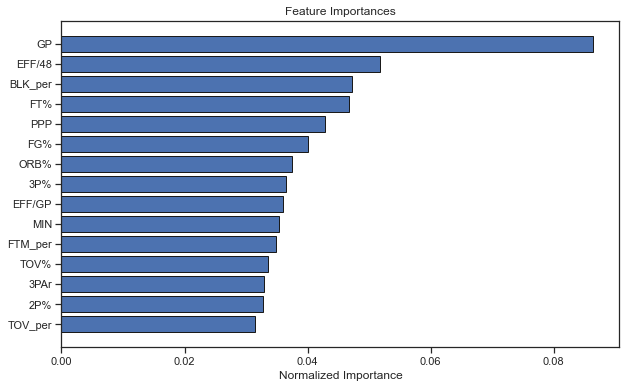

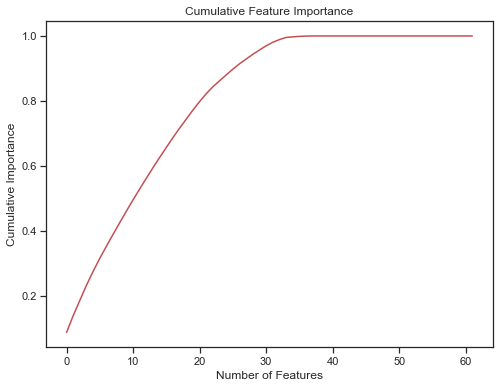

27 features required for 0.90 of cumulative importance


In [72]:
norm_feature_importances = plot_feature_importances(feature_importances_1)

In [73]:
print('There are %d features with 0.0 importance' % len(zero_features_1))
train_f1 = train.drop(columns = zero_features_1)
test_f1 = test.drop(columns = zero_features_1)

print('Train shape after drop: ', train_f1.shape)
print('Test shape after drop: ', test_f1.shape)

There are 24 features with 0.0 importance
Train shape after drop:  (8000, 38)
Test shape after drop:  (3799, 38)


In [74]:
# Save dataset
train_f1.to_csv("../data/processed/train_f1.csv", index = False)
test_f1.to_csv("../data/processed/test_f1.csv", index = False)

##### **[6.10]** Evaluate the resulting model after dropping 0 importance feature

In [75]:
## get dataset
train = pd.read_csv("../data/processed/train_f1.csv")
test = pd.read_csv("../data/processed/test_f1.csv")
train.shape, test.shape

submission, feature_importances, zero_features, metrics = model(train, test)
metrics

((8000, 38), (3799, 38))

Training Data Shape:  (8000, 38)
Testing Data Shape:  (3799, 38)


fold     train     valid
0        0  0.918330  0.696518
1        1  0.883115  0.705415
2        2  0.809965  0.717754
3        3  0.839775  0.690267
4        4  0.874058  0.689858
5  overall  0.865048  0.693995

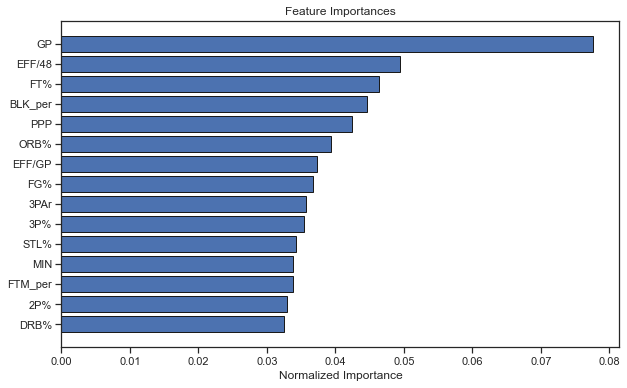

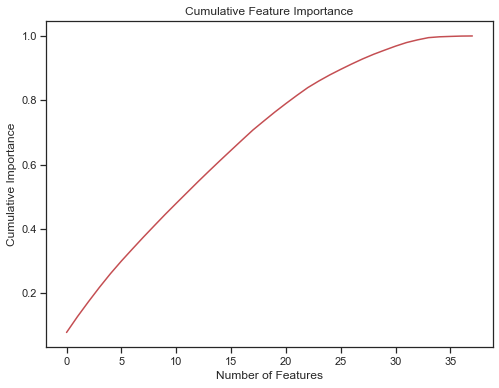

27 features required for 0.90 of cumulative importance


In [76]:
norm_feature_importances = plot_feature_importances(feature_importances)

In [77]:
print('There are %d features with 0.0 importance' % len(zero_features))

There are 0 features with 0.0 importance


In [78]:
# save to csv
final_X_dropped = pd.concat([train, test])
final_X_dropped.to_csv("../data/processed/final_X_dropped.csv", index = False)

Now all features in the dataset has importance > 0. We will keep and use these feature for modeling. 
In this dataset we:

* drop all collinear features with correlation coefficient grater than 0.9
* droped features with missing value greater than 75%
* removed no imformation features

##### **[6.11]** Reintroduce domain knowledge 'PER', 'PPER', 'NPER'

After group discussion, the features: 'PER', 'PPER' are 'NPER' considered important to the model even it is dropped in previous section, so we added these features back.

In [79]:
# Load dataset
train = pd.read_csv("../data/processed/train_f1.csv")
test = pd.read_csv("../data/processed/test_f1.csv")
all_X_domain = pd.read_csv("../data/processed/all_X_domain.csv")

train.shape, test.shape, all_X_domain.shape


((8000, 38), (3799, 38), (11799, 77))

In [80]:
# Combine train and test X
final_add = pd.concat([train, test]).reset_index(drop=True)
final_add['PER'] = all_X_domain['PER']
final_add['PPER'] = all_X_domain['PPER']
final_add['NPER'] = all_X_domain['NPER']


In [81]:
# check our final features
final_add

GP   MIN   PTS        FG%  3P Made        3P%  FTM        FT%  OREB  \
0      80.0  24.3   7.8  46.875000      0.1  33.333333  2.0  68.965517   2.2   
1      75.0  21.8  10.5  53.164557      NaN        NaN  2.4  66.666667   3.6   
2       NaN  19.1   4.5  42.222222      0.4  33.333333  0.4  66.666667   0.6   
3      63.0  19.1   8.2  52.238806      0.3  37.500000  0.9  60.000000   0.8   
4      63.0  17.8   3.7  50.000000      0.5  35.714286  0.2  40.000000   2.4   
...     ...   ...   ...        ...      ...        ...  ...        ...   ...   
11794   NaN  21.2   8.7  50.746269      0.0        NaN  1.7  68.000000   1.9   
11795  49.0  16.3   6.4  43.939394      NaN        NaN  1.0  52.631579   1.7   
11796  53.0   9.9   2.1  44.444444      NaN        NaN  0.6  60.000000   0.7   
11797   NaN  38.3  14.5  45.762712      0.5  41.666667  2.5  86.206897   1.5   
11798  55.0  12.0   3.0  44.000000      0.1  16.666667  0.9  81.818182   0.7   

       DREB  AST  STL  BLK  TOV  3P Made_anom  3P%_anom        2P%       FTr  \
0       2.0  3.2  1.1  0.2  1.6             0         0  47.540984  0.453125   
1       3.7  0.7  0.5  0.6  1.4             0         0        NaN  0.455696   
2       1.8  0.8  0.4  0.2  0.6             0         0  45.454545  0.133333   
3       2.0  1.8  0.4  0.1  1.9             0         0  54.237288  0.223881   
4       2.7  0.4  0.4  0.6  0.7             0         0  60.000000  0.147059   
...     ...  ...  ...  ...  ...           ...       ...        ...       ...   
11794   2.3  1.5  0.6  0.3  2.0             0         0  50.746269  0.373134   
11795   2.8  0.4  0.4  0.4  0.7             0         0        NaN  0.287879   
11796   1.0  0.4  0.4  0.2  0.5             0         0        NaN  0.555556   
11797   4.0  3.7  1.3  0.3  2.4             0         0  46.226415  0.245763   
11798   2.0  0.6  0.3  0.2  1.2             0         0  52.631579  0.440000   

           FTMr      3PAr   AST/TOV       ASTR       APM  FT_miss       DRB%  \
0      0.666667  0.046875  2.000000  25.649247  0.320988      0.9   6.584362   
1      0.571429       NaN  0.500000   6.042818  0.481651      1.2  13.577982   
2      0.210526  0.266667  1.333333  12.978585  0.235602      0.2   7.539267   
3      0.257143  0.119403  0.947368  16.274864  0.429319      0.6   8.376963   
4      0.117647  0.411765  0.571429   8.474576  0.207865      0.3  12.134831   
...         ...       ...       ...        ...       ...      ...        ...   
11794  0.500000 -0.000000  0.750000  13.274336  0.410377      0.8   8.679245   
11795  0.344828       NaN  0.571429   4.686036  0.392638      0.9  13.742331   
11796  0.750000       NaN  0.800000  12.738854  0.212121      0.4   8.080808   
11797  0.462963  0.101695  1.541667  19.294952  0.378590      0.4   8.355091   
11798  0.818182  0.240000  0.500000  12.541806  0.250000      0.2  13.333333   

            ORB%    EFF/GP     EFF/48       PPP      STL%   STL/TOV  \
0       7.242798  0.132500  20.938272  0.840880  7.242798  0.687500   
1      13.211009  0.177333  29.284404  0.964719  3.669725  0.357143   
2       2.513089       NaN  12.314136  0.838926  3.350785  0.666667   
3       3.350785  0.120635  19.099476  0.885529  3.350785  0.210526   
4      10.786517  0.119048  20.224719  0.856481  3.595506  0.571429   
...          ...       ...        ...       ...       ...       ...   
11794   7.169811       NaN  20.830189  0.887755  4.528302  0.300000   
11795   8.343558  0.138776  20.024540  0.786627  3.926380  0.571429   
11796   5.656566  0.054717  14.060606  0.766423  6.464646  0.800000   
11797   3.133159       NaN  20.177546  0.936935  5.430809  0.541667   
11798   4.666667  0.072727  16.000000  0.717017  4.000000  0.250000   

            TOV%       USGr   FTM_per   BLK_per   TOV_per   2P%_log  \
0      17.248814  15.416626  3.950617  0.395062  3.160494  3.882614   
1      12.862918  17.995229  5.284404  1.321101  3.082569       NaN   
2      11.185682  10.308691  1.005236  0.502618  1.507853  3

In [82]:
# Save dataset
final_add.to_csv("../data/processed/final_add.csv", index = False)

In [83]:
# Evaluate current dataset
data = pd.read_csv("../data/processed/final_add.csv")
data = data.reset_index(drop=True)

train = data.iloc[:len(y_train), :]
train_ids = train.index
train_labels = y_train_raw.reset_index(drop=True)

test = data.iloc[len(y_train):, :]
test_ids = X_test.index

train.shape, test.shape

submission, feature_importances, zero_features, metrics = model(train, test)
metrics

((8000, 41), (3799, 41))

Training Data Shape:  (8000, 41)
Testing Data Shape:  (3799, 41)


fold     train     valid
0        0  0.884700  0.701928
1        1  0.878495  0.700537
2        2  0.806784  0.718095
3        3  0.829227  0.688266
4        4  0.867496  0.684512
5  overall  0.853340  0.692327

We can see both the train and validation auc score are higher than before. Which indicates reintroducing the three variables are having some positive effects on the model.

In [84]:
# Save dataset
train.to_csv("../data/processed/train_add.csv", index = False)
test.to_csv("../data/processed/test_add.csv", index = False)

## 7. K mean cluster

##### **[7.1]** Prepare dataset

In [85]:
# Load train set
train = pd.read_csv("../data/processed/train_add.csv")
train_labels = y_train_raw.reset_index(drop=True)

# Load test set
test = pd.read_csv("../data/processed/test_add.csv")

# Check shape of train and test
train.shape, test.shape

((8000, 41), (3799, 41))

In [86]:
# fill all np.nan with mode of each column
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_train = imputer.fit_transform(train)
X_test = imputer.transform(test)

In [87]:
# Combine test & train to form all_X
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
all_X = X_train.append(X_test)
all_X.shape

(11799, 41)

In [88]:
# Standardise all_X to achieve better result on K-Mean clustering
scaled_data = StandardScaler().fit_transform(all_X)

##### **[7.2]** Find optimal number of cluster

In [89]:
# Find best number of clusters
sil = []
kmax = 12
my_range=range(2,kmax+1)
for i in my_range:
    kmeans = cluster.KMeans(n_clusters = i).fit(scaled_data)
    labels = kmeans.labels_
    sil.append(silhouette_score(scaled_data, labels, metric =  
    'correlation'))

Text(0.5, 0, 'k')

Text(0, 0.5, 'Silhouette Score')

Text(0.5, 1.0, 'Silhouette Score by K')

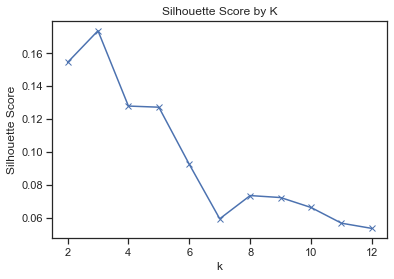

In [90]:
# Plot it, finding 2 is the ideal overall (all columns) cluster
plt.plot(my_range, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by K')
plt.show()

We can see the clustering is the best at 3. So we'll use 3 as the number of cluster in Gaussian Mixture.
Below cell is for K-mean clustering, not shown here. This version is for Gaussian Mixture shown later.

In [ ]:
# all_X_cluster['LABELS'] = cluster.KMeans(n_clusters=3).fit(scaled_data).labels_

# #Analyze labels
# clusters = pd.DataFrame(columns=(all_X_cluster.iloc[:, :]).columns)
# for i in range(0, 3):
#     a = all_X_cluster[all_X_cluster['LABELS'] == i].mean()
#     clusters = clusters.append(a, ignore_index=True)

# #Show information we want
# clusters

##### **[7.3]** Classify clusters using GaussianMixture

In [91]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, random_state=9999)
gmm.fit(all_X)
gmm.predict(all_X)

GaussianMixture(n_components=3, random_state=9999)

array([0, 1, 2, ..., 1, 0, 2])

In [92]:
Label = pd.DataFrame(gmm.predict(all_X))
all_X['Label'] = Label

##### **[7.4]** Seperate dataset

In [93]:
X_train = all_X.iloc[:len(y_train), :]
X_test = all_X.iloc[len(y_train):, :]
X_train.shape, y_train.shape, X_test.shape

((8000, 42), (8000, 1), (3799, 42))

##### **[6.4]** Standardise

In [94]:
# Instantiate the StandardScaler
scaler = StandardScaler()

# Fit and apply the scaling on data and test
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [95]:
# Save the scaler into the folder models and call the file scaler.joblib
dump(scaler, '../models/scaler.joblib')

['../models/scaler.joblib']

##### **[6.4]** Split dataset & Save

In [96]:
# Split the data (80%) randomly with random_state=8 into 2 different sets: training (80%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  random_state=0,
                                                  stratify=y_train)

In [97]:
np.save('../data/processed/X_train', X_train)
np.save('../data/processed/y_train', y_train)

np.save('../data/processed/X_val', X_val)
np.save('../data/processed/y_val', y_val)

np.save('../data/processed/X_test', X_test)